# Module 3 Project - Whisky Sommelier
# Classification Modeling
By: **Maura Cerow**, **Rajeev Panwar** and **Bryan Santos**

This project aims to build the first module of a comprehensive whisky recommendation engine, an **automated whisky sommelier**. We would like this to act as a go-to "middle-man" between distributors, bars and consumers.

This notebook includes all classification models, their scores, hypertuning and corresponding model evaluation before selecting the best and final model.

## Dataset

## Package Imports and Data Load

In [1]:
### Needed libraries for Classification Modeling ###

### Basic packages ###
import numpy as np
import pandas as pd 

### Modeling ###
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve
import imblearn
from sklearn.preprocessing import LabelBinarizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

sns.set()

%matplotlib inline

### Suppress notebook warnings ###
import warnings
warnings.filterwarnings('ignore')

### Pandas settings to avoid exponential form and display all columns ###
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

/Users/Bryan/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
df = pd.read_csv("whisky_df_clean.csv")

Prepare dataframe that would summarize all the metrics from the models.

In [3]:
global summary_df
summary_df = pd.DataFrame(columns=['Model', 'Imbalance Handling','Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score'])
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score


## Functions for Reuse

These are all the functions for reuse separated into corresponding Data Science process. This makes for faster modeling and cleaner code.

### Data Pre-Processing

### Train Test Split

In [4]:
def data_split(features, target):
    '''
    This function splits the dataset into training and testing.
    
    Parameter: 
        Features: independent variables
        Target: dependent variable        
          
    Returns: 
        This returns the dataset split into four categories: features training and testing,
        target training and testing.
    
    '''
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42,test_size=0.2)
    return {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

### Scaling

In [5]:
def scaler(features_train, features_test):

    '''
    This function scales/standardizes the features data with values 0 to 1. The resulting
    columns are best used when comparing weights.
    
    Parameter: 
        features_train: independent variables for training
        features_test: independent variables for testing       
          
    Returns: 
        This returns the standardized features.
    
    '''
    
    scaler = StandardScaler()  
    scaler.fit(features_train)
        
    X_train_scaled = scaler.transform(features_train)  
    X_test_scaled = scaler.transform(features_test)  
    
    return {'X_train_scaled': X_train_scaled, 'X_test_scaled': X_test_scaled}

### Clasification Methods

#### Logistic Regression

In [6]:
def logistic_regression(features, target):
    '''
    This function runs logistic regression and outputs the model used for fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
          
    Returns: 
        This returns the logistic regression model.
    '''
    logistic_regression_model = LogisticRegression().fit(features, target)
    return logistic_regression_model

#### K-Nearest Neighbors

In [7]:
def knn(features, target, n):
    '''
    This function runs k-nearest neighbor method and outputs the model used for fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        n: number of neighbors parameter
    Returns: 
        This returns the knn model.
    '''
    knn_model = KNeighborsClassifier(n_neighbors=n)
    knn_model = knn_model.fit(features, target)
    return knn_model

In [8]:
def knn_best_model(features_train, target_train, features_test, target_test):
    '''
    This function runs k-nearest neighbor models and checks the best n_neighbors variable.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
          
    Returns: 
        This returns a comparison of knn results with different number of neighbors as
        parameter.
    '''
    k_range = list(range(1, 11))
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(features_train, target_train)
        y_predict = knn.predict(features_test)
        score = f1_score(target_test, y_predict, average='weighted')
        k_scores.append(score)
        print("n = " + str(k) + " - " + str(score))
        
    plt.figure(figsize=(12, 6))  
    plt.plot(range(1, 11), k_scores, color='red', linestyle='dashed', marker='o',  
             markerfacecolor='blue', markersize=10)
    plt.title('F1 score by K Value')  
    plt.xlabel('K Value')  
    plt.ylabel('F1 Score') 
    plt.show()

#### Decision Trees

In [9]:
def decision_tree(features, target, depth):
    '''
    This function runs decision tree algorithm method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        depth: maximum depth parameter
    Returns: 
        This returns the decision tree model.
    '''
    decision_tree_model = DecisionTreeClassifier(max_depth = depth)
    decision_tree_model.fit(features, target)    
    
    dot_data = StringIO()
    export_graphviz(decision_tree_model, out_file=dot_data,  
                    rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    Image(graph.create_png())
    return decision_tree_model

In [10]:
def decision_tree_best_model(features, target):
    '''
    This function runs decision tree models models and checks the best depth parameter.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
          
    Returns: 
        This returns a comparison of decision tree results with different depths as
        parameter.
    '''
    depth_range = range(1,10)
    val = []
    for depth in depth_range:
        ctree = DecisionTreeClassifier(max_depth = depth)
        depth_score = cross_val_score(ctree, features, target, cv = 10)
        val.append(depth_score.mean())
        print(str(depth_range) + " - " + str(depth_score.mean()))
    plt.figure(figsize = (10,10))
    plt.plot(depth_range, val)
    plt.xlabel('range of depth')
    plt.ylabel('cross validated values')
    plt.show()

#### Random Forest

In [11]:
def random_forest(features, target, params, baseline):
    '''
    This function runs random forest algorithm method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        params: parameters after hypertuning
        baseline: set to True if to run initial, baseline model
    Returns: 
        This returns the random forest model.
    '''
    if (params == None) & (baseline == True):
        random_forest_model = RandomForestClassifier(random_state = 42)
        random_forest_model.fit(features, target)
        print(random_forest_model.get_params())
        return random_forest_model
    else:
        random_forest_model = RandomForestClassifier(**params, random_state = 42)
        random_forest_model.fit(features, target)
        return random_forest_model

#### Adaptive Boosting

In [12]:
def adaboost(features, target, params, baseline):
    '''
    This function runs adaptive boosting ensemble method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        params: parameters after hypertuning
        baseline: set to True if to run initial, baseline model
    Returns: 
        This returns the adaptive boosting model.
    '''
    if (params == None) & (baseline == True):
        adaboost_model = AdaBoostClassifier(n_estimators=100, base_estimator= None,learning_rate=1, random_state = 42)
        adaboost_model.fit(features, target)
        print(adaboost_model)
        return adaboost_model
    else:
        adaboost_model = AdaBoostClassifier(**params)
        adaboost_model.fit(features, target)
        return adaboost_model

#### Gradient Boosting

In [13]:
def gradientboost(features, target, params, baseline):
    '''
    This function runs gradient boosting ensemble method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        params: parameters after hypertuning
        baseline: set to True if to run initial, baseline model
    Returns: 
        This returns the gradient boosting model.
    '''
    if (params == None) & (baseline == True):
        params_baseline = {
        'n_estimators': 1,
        'max_depth': 1,
        'learning_rate': 1,
        'criterion': 'mse',
        'random_state': 42
        }

        gradient_boost_model = GradientBoostingClassifier(**params_baseline)
        gradient_boost_model.fit(features, target)
        return gradient_boost_model

    else:
        gradient_boost_model = GradientBoostingClassifier(**params, random_state = 42)
        gradient_boost_model.fit(features, target)
        return gradient_boost_model

#### Extreme Gradient Boosting (XGBoost)

In [14]:
def xgboost(features, target, params, baseline):
    '''
    This function runs xgboosting ensemble method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        params: parameters after hypertuning
        baseline: set to True if to run initial, baseline model
    Returns: 
        This returns the xgboosting model.
    '''
    if (params == None) & (baseline == True):
        xgboost_model = XGBClassifier(n_jobs = -1)
        xgboost_model.fit(features, target)
        print(xgboost_model)
        return xgboost_model
    else:
        xgboost_model = XGBClassifier(**params)
        xgboost_model.fit(features, target)
        return xgboost_model

#### Naive Bayes

In [15]:
def naive_bayes(features, target):
    '''
    This function runs naive bayes method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       

    Returns: 
        This returns the naive bayes model.
    '''
    naive_bayes_model = GaussianNB()
    naive_bayes_model.fit(features, target)
    return naive_bayes_model

### Scoring and Evaluation

#### Grid Search Cross Validation

In [16]:
def grid_search_cv(model, features, target, params, n_jobs, cv):
    '''
    This function automatically runs grid search cross validation for hyperparameter tuning
    and determining the set of parameters that would produce the best results.
    
    Parameter: 
        model: model to be used for fitting
        features: independent variables
        target: dependent variable       
        params: parameters after hypertuning
        n_jobs: number of parallel jobs to run
        cv: number of cross-validation folds
        
    Returns: 
        This returns the best parameters.
    '''
    grid_search = GridSearchCV(estimator = model, param_grid = params, 
                          n_jobs=n_jobs, cv = cv)
    grid_search.fit(features, target)
    return grid_search.best_params_

#### Standard Scores

In [17]:
def score_model(model, handling, features_train, target_train, features_test, target_test):
    '''
    This function automatically runs the model inputted and calculates the following
    metrics: accuracy, precision, recall, and F1 score. Then this appends to the summary
    table initialized earlier that would list all results of all models run. This is for
    easier comparison and model evaluation. Finally, this also outputs the corresponding
    confusion matrix of the model.
    
    Parameter: 
        model: model to be used for fitting
        features_train: independent variables for training
        target_train: dependent variable for training      
        features_train: independent variables for testing
        target_train: dependent variable for testing  
        
    Returns: 
        This returns all the pertinent metrics, confusion matrix and appends to the summary
        dataframe.
    '''
    predictions = model.predict(features_test)
    accuracy = metrics.accuracy_score(target_test, predictions)
    precision = metrics.precision_score(target_test, predictions, average='weighted')
    recall = metrics.recall_score(target_test, predictions, average='weighted')
    f1 = metrics.f1_score(target_test, predictions, average='weighted')
    y_pred_prob = model.predict_proba(features_test)[:, 1]
    
    lb = LabelBinarizer()
    lb.fit(target_test)
    y_test = lb.transform(target_test)
    
    y_pred = model.predict(features_test)
    y_pred = lb.transform(y_pred)
    #return roc_auc_score(y_test, y_pred, average=average)
    
    roc_auc = metrics.roc_auc_score(y_test, y_pred, average="weighted")
    #cv = cross_val_score(model, features, target, cv=10, scoring='roc_auc').mean()
        
    cm = confusion_matrix(target_test, predictions)
    classes = ['Scotch', 'American', 'Canadian', 'Irish', 'Japanese']
    
    plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
    global summary_df
    summary_df = summary_df.append({'Model': str(model).split('(')[0], 'Imbalance Handling' : handling , 'Accuracy' : accuracy, 'Precision' : precision, 'Recall': recall,  'F1 Score': f1, 'ROC AUC Score' : roc_auc} , ignore_index=True)

#### Confusion Matrix

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    This function automatically plots the confusion matrix.
    
    Parameter: 
        cm: confusion matrix from the scoring function
        normalize: True if to be normalized
        title: title of the confusion matrix
        cmap: plotting method
        
    Returns: 
        This returns a graphical confusion matrix
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Handling Class Imbalance

#### Random Undersampling

In [19]:
def random_undersampling(X_train, y_train):
    '''
    This function runs random undersampling to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with random undersampling implemented.
    '''
    rus = RandomUnderSampler()
    X_train, y_train = rus.fit_sample(features, target)
    return {'X_train': X_train, 'y_train': y_train}

#### Random Oversampling

In [20]:
def random_oversampling(X_train, y_train):
    '''
    This function runs random oversampling to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with random oversampling implemented.
    '''
    ros = RandomOverSampler()
    X_train, y_train = ros.fit_sample(features, target)
    return {'X_train': X_train, 'y_train': y_train}

#### Tomek Links

In [21]:
def tomek_links(X_train, y_train):
    '''
    This function runs tomek link undersampling to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with tomek link undersampling implemented.
    '''
    tl = TomekLinks()
    X_train, y_train = tl.fit_sample(features, target)
    return {'X_train': X_train, 'y_train': y_train}

#### Cluster Centroids

In [22]:
def cluster_centroids(X_train, y_train):
    '''
    This function runs cluster centroids to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with cluster centroids implemented.
    '''
    cc = ClusterCentroids()
    X_train, y_train = cc.fit_sample(features, target)
    return {'X_train': X_train, 'y_train': y_train}

#### SMOTE

In [23]:
def smote(X_train, y_train):
    '''
    This function runs SMOTE to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with SMOTE implemented.
    '''
    smote = SMOTE()
    X_train, y_train = smote.fit_sample(features, target)
    return {'X_train': X_train, 'y_train': y_train}

#### SMOTETomek

In [24]:
def smote_tomek(X_train, y_train):
    '''
    This function runs a combination of SMOTE and tomek link to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with SMOTE and tomek link implemented.
    '''
    smt = SMOTETomek()
    X_train, y_train = smt.fit_sample(features, target)
    return {'X_train': X_train, 'y_train': y_train}

## Feature Selection

This is where the target and features are to be declared because all the modelling will happen automatically. 

In [25]:
df.columns

Index(['name', 'type', 'price', 'expert_score', 'user_rating', 'description',
       'abv', 'style', 'cask', 'review', 'smoky', 'peaty', 'spicy', 'herbal',
       'oily', 'full-bodied', 'rich', 'sweet', 'briny', 'salty', 'vanilla',
       'tart', 'fruity', 'floral', 'country'],
      dtype='object')

Set dependent variable

In [26]:
target = df['country']

Set independent variables

In [27]:
features = df[['smoky', 'peaty', 
               'spicy', 'herbal', 'oily', 'full-bodied', 'rich', 'sweet', 'briny', 'salty', 'vanilla',
               'tart', 'fruity', 'floral']]

In [28]:
df.shape

(2662, 25)

## Model Fitting and Hyperparameter Tuning (without class imbalance handling)

Train test split of the dataset as best practice prior to modeling.

In [29]:
split = data_split(features,target)

### Logistic Regression

In [30]:
logistic_regression_model = logistic_regression(split['X_train'], split['y_train'])

Confusion Matrix, without normalization
[[148  45   5   2   1]
 [ 35 200   6   0   1]
 [  6  17   8   0   0]
 [ 20  13   1   0   0]
 [ 18   6   0   0   1]]


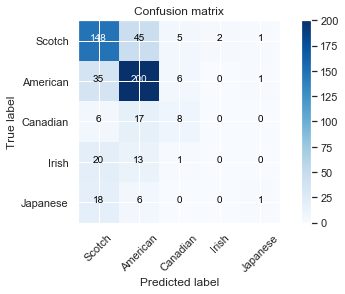

In [31]:
score_model(logistic_regression_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [32]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726


### K-Nearest Neighbor

In [33]:
scaled = scaler(split['X_train'], split['X_test'])

In [34]:
knn_model = knn(scaled['X_train_scaled'], split['y_train'], 1)

Confusion Matrix, without normalization
[[139  38   7  12   5]
 [ 46 167  17   7   5]
 [  3   6  19   2   1]
 [ 19   7   4   4   0]
 [  9   4   1   3   8]]


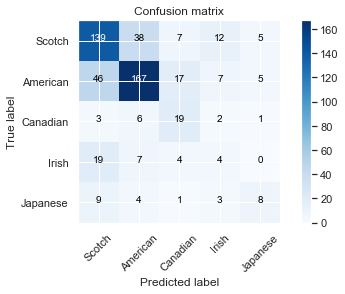

In [35]:
score_model(knn_model, "None", scaled['X_train_scaled'], split['y_train'], scaled['X_test_scaled'], split['y_test'])

In [36]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726


n = 1 - 0.6314965743569134
n = 2 - 0.6297046576593031
n = 3 - 0.6517469306485675
n = 4 - 0.6723714025893806
n = 5 - 0.6690310775178933
n = 6 - 0.65563639699497
n = 7 - 0.6548336645002282
n = 8 - 0.6484430540449714
n = 9 - 0.6610784560498008
n = 10 - 0.6432366673349994


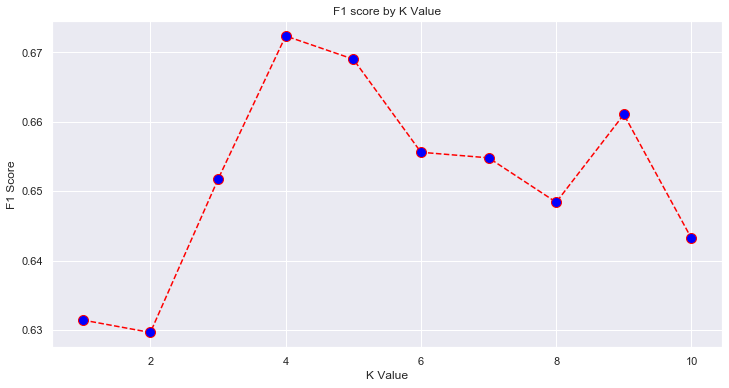

In [37]:
knn_best_model(scaled['X_train_scaled'], split['y_train'], scaled['X_test_scaled'], split['y_test'])

In [38]:
knn_model = knn(scaled['X_train_scaled'], split['y_train'], 4)

Confusion Matrix, without normalization
[[169  23   5   2   2]
 [ 50 177  12   2   1]
 [  5   5  20   1   0]
 [ 20  10   3   1   0]
 [ 16   4   1   0   4]]


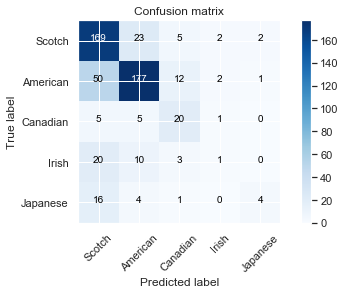

In [39]:
score_model(knn_model, "None", scaled['X_train_scaled'], split['y_train'], scaled['X_test_scaled'], split['y_test'])

In [40]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762


### Decision Tree

In [41]:
decision_tree_model = decision_tree(split['X_train'], split['y_train'], 5)

Confusion Matrix, without normalization
[[146  50   5   0   0]
 [ 51 187   4   0   0]
 [ 10  18   3   0   0]
 [ 23  11   0   0   0]
 [ 20   5   0   0   0]]


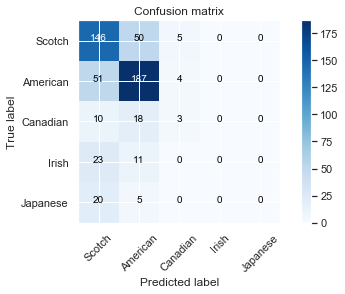

In [42]:
score_model(decision_tree_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [43]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690


range(1, 10) - 0.580106741075383
range(1, 10) - 0.580106741075383
range(1, 10) - 0.6007640180706882
range(1, 10) - 0.6233169456993535
range(1, 10) - 0.6327066170608557
range(1, 10) - 0.6383581362388164
range(1, 10) - 0.6289352467003277
range(1, 10) - 0.6171760120471255
range(1, 10) - 0.6298653556559483


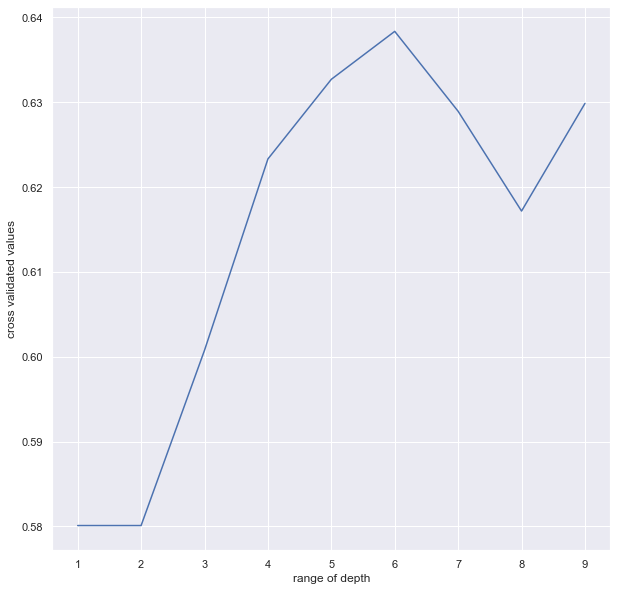

In [44]:
decision_tree_best_model(split['X_train'], split['y_train'])

In [45]:
decision_tree_model = decision_tree(split['X_train'], split['y_train'], 6)

Confusion Matrix, without normalization
[[137  52   8   0   4]
 [ 54 181   6   0   1]
 [ 10   9  12   0   0]
 [ 23   7   1   0   3]
 [ 13   6   0   0   6]]


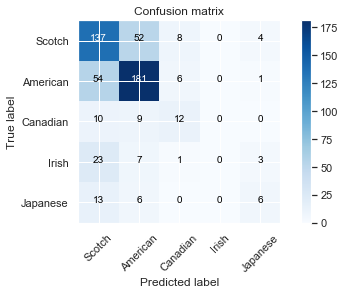

In [46]:
score_model(decision_tree_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [47]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699


### Random Forest

In [48]:
random_forest_model = random_forest(split['X_train'], split['y_train'], None, True)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Confusion Matrix, without normalization
[[166  32   3   0   0]
 [ 26 210   5   1   0]
 [  4   7  20   0   0]
 [ 20  12   1   1   0]
 [ 17   5   1   0   2]]


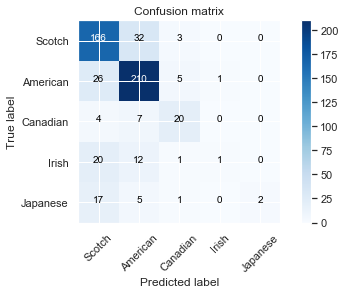

In [49]:
score_model(random_forest_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [50]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792


In [51]:
# n_estimators = [10, 50, 100, 150, 200]
# max_features = ['auto', 'sqrt','log2', 14]
# max_depth =[2,5,7,10]
# min_samples_leaf=[1]
# min_samples_split=[2]
# bootstrap = [True, False]

n_estimators = [200]
max_features = ['auto']
max_depth =[10]
min_samples_leaf=[1]
min_samples_split=[2]
bootstrap = [True]

# Create the random grid
param_grid = {  'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split,
                'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [200], 'max_features': ['auto'], 'max_depth': [10], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [True]}


In [52]:
params = grid_search_cv(random_forest_model, features, target, param_grid, 4, 5)
print (params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [53]:
random_forest_model = random_forest(split['X_train'], split['y_train'], params, False)

Confusion Matrix, without normalization
[[162  36   3   0   0]
 [ 29 210   3   0   0]
 [  4   8  19   0   0]
 [ 22  11   1   0   0]
 [ 19   5   0   0   1]]


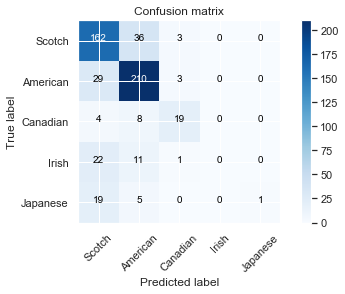

In [54]:
score_model(random_forest_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [55]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778


### Adaptive Boosting

In [56]:
adaboost_model = adaboost(split['X_train'], split['y_train'], None, True)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=42)


Confusion Matrix, without normalization
[[125  48   7   7  14]
 [ 35 171  27   5   4]
 [  2   8  18   3   0]
 [ 19   8   3   3   1]
 [ 11   5   0   1   8]]


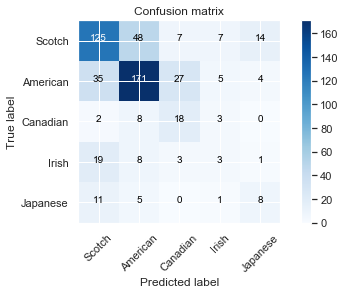

In [57]:
score_model(adaboost_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [58]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709


In [59]:
# n_estimators = [500, 1000, 2000]
# learning_rate = [.001,0.01,.1]
# random_state = [42]

n_estimators = [500]
learning_rate = [.1]
random_state = [42]

param_grid = {  'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'random_state': random_state
             }
print(param_grid)

{'n_estimators': [500], 'learning_rate': [0.1], 'random_state': [42]}


In [60]:
params = grid_search_cv(adaboost_model, features, target, param_grid, 4, 5)
print (params)

{'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 42}


In [61]:
adaboost_model = adaboost(split['X_train'], split['y_train'], params, False)

Confusion Matrix, without normalization
[[137  60   2   1   1]
 [ 37 195  10   0   0]
 [  4  14  13   0   0]
 [ 23   9   2   0   0]
 [ 19   4   0   0   2]]


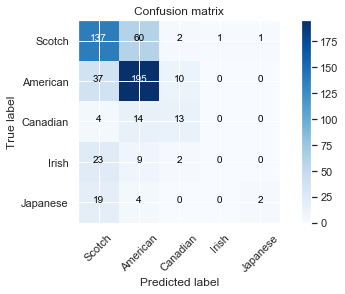

In [62]:
score_model(adaboost_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [63]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710


### Gradient Boost

In [64]:
gradient_boost_model = gradientboost(split['X_train'], split['y_train'], None, True)

Confusion Matrix, without normalization
[[115  86   0   0   0]
 [ 63 179   0   0   0]
 [  6  25   0   0   0]
 [ 14  20   0   0   0]
 [ 23   2   0   0   0]]


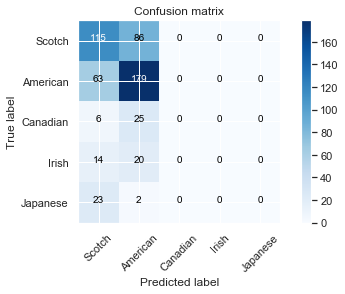

In [65]:
score_model(gradient_boost_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [66]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


In [67]:
# param_grid = {
#     "loss":["deviance", "exponential"],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "min_samples_split": [2],
#     "min_samples_leaf": [1],
#     "max_depth":[3,5,10],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[1.0],
#     "n_estimators":[50, 100, 200]
#     }

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.1],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[10],
    "max_features":["auto"],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
    "n_estimators":[100]
    }


# print(param_grid)

In [68]:
params = grid_search_cv(gradient_boost_model, features, target, param_grid, 4, 5)
print (params)

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [69]:
gradient_boost_model = gradientboost(split['X_train'], split['y_train'], params, False)

Confusion Matrix, without normalization
[[155  37   5   3   1]
 [ 26 205   7   4   0]
 [  4  11  16   0   0]
 [ 20  11   1   2   0]
 [ 17   5   0   0   3]]


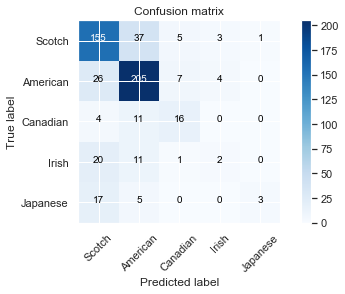

In [70]:
score_model(gradient_boost_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [71]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### XGBoost

In [72]:
xgboost_model = xgboost(split['X_train'], split['y_train'], None, True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Confusion Matrix, without normalization
[[157  38   3   1   2]
 [ 34 203   5   0   0]
 [  4   9  18   0   0]
 [ 22  11   1   0   0]
 [ 16   4   0   0   5]]


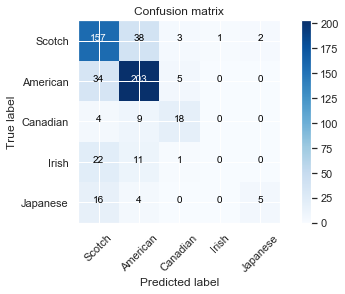

In [73]:
score_model(xgboost_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [74]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


In [75]:
# param_grid = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

param_grid = {
        'min_child_weight': [10],
        'gamma': [1.5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5]
        }

# print(param_grid)

In [76]:
params = grid_search_cv(xgboost_model, features, target, param_grid, 4, 5)
print (params)

{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0}


In [77]:
xgboost_model = xgboost(split['X_train'], split['y_train'], params, False)

Confusion Matrix, without normalization
[[157  38   3   1   2]
 [ 33 205   3   1   0]
 [  6  10  15   0   0]
 [ 20  11   3   0   0]
 [ 15   4   0   0   6]]


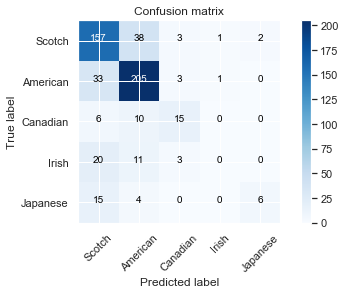

In [78]:
score_model(xgboost_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [79]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### Naive Bayes

In [80]:
naive_bayes_model = naive_bayes(split['X_train'], split['y_train'])

Confusion Matrix, without normalization
[[ 88  88  13  12   0]
 [ 23 184  32   3   0]
 [  1   7  22   1   0]
 [  8  13   8   5   0]
 [ 10   9   3   1   2]]


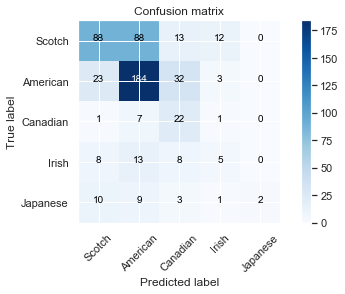

In [81]:
score_model(naive_bayes_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [82]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


## Model Fitting and Hyperparameter Tuning (with Random Undersampling)

In [83]:
split = data_split(features,target)

In [84]:
balanced = random_undersampling(split['X_train'], split['y_train'])

### Logistic Regression

In [85]:
logistic_regression_model = logistic_regression(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 86  25  18  35  37]
 [ 17 123  45  36  21]
 [  1   1  24   4   1]
 [  9   3   8  11   3]
 [  6   2   0   4  13]]


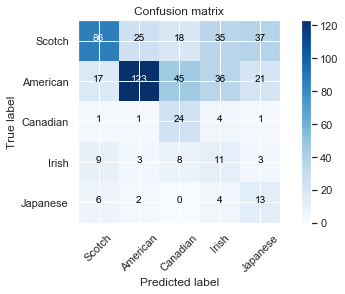

In [86]:
score_model(logistic_regression_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [87]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### K-Nearest Neighbor

In [88]:
scaled = scaler(balanced['X_train'], split['X_test'])

In [89]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[ 98  19  20  39  25]
 [ 30 118  34  32  28]
 [  1   0  30   0   0]
 [  2   0   2  29   1]
 [  0   0   0   0  25]]


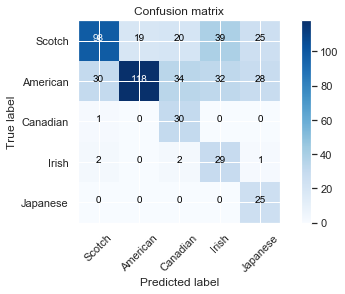

In [90]:
score_model(knn_model, "Random Undersampling", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [91]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


n = 1 - 0.5853415160516201
n = 2 - 0.5980767193624753
n = 3 - 0.5782231600031319
n = 4 - 0.5118420685836942
n = 5 - 0.5402395700832616
n = 6 - 0.517689921566366
n = 7 - 0.5273858792666745
n = 8 - 0.5214861927320802
n = 9 - 0.5292874079079948
n = 10 - 0.5213646036816769


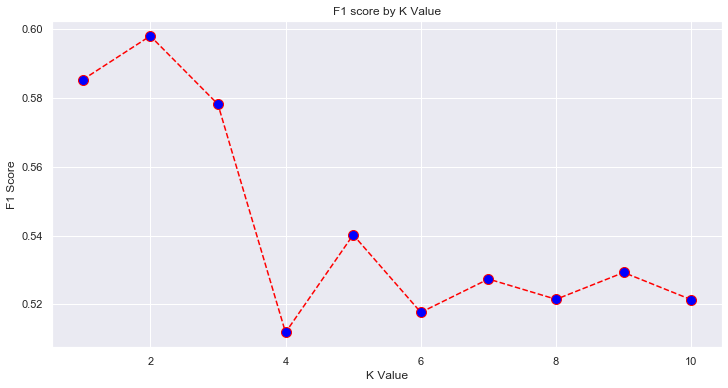

In [92]:
knn_best_model(scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [93]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[ 98  19  20  39  25]
 [ 30 118  34  32  28]
 [  1   0  30   0   0]
 [  2   0   2  29   1]
 [  0   0   0   0  25]]


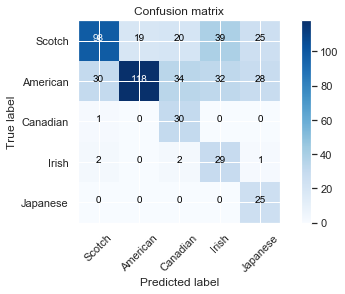

In [94]:
score_model(knn_model, "Random Undersampling", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [95]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### Decision Tree

In [96]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 5)

Confusion Matrix, without normalization
[[ 40  46   7  55  53]
 [ 12 140  17  52  21]
 [  0   4  17  10   0]
 [  0   6   1  15  12]
 [  0   5   0   0  20]]


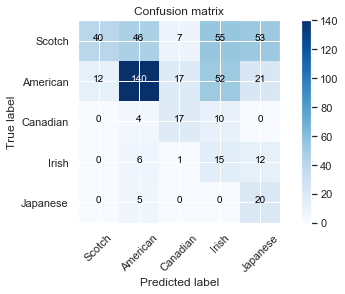

In [97]:
score_model(decision_tree_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [98]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


range(1, 10) - 0.32805194805194804
range(1, 10) - 0.37129870129870124
range(1, 10) - 0.4414610389610389
range(1, 10) - 0.4812662337662338
range(1, 10) - 0.4723701298701298
range(1, 10) - 0.47392857142857137
range(1, 10) - 0.45405844155844155
range(1, 10) - 0.46324675324675324
range(1, 10) - 0.4343181818181819


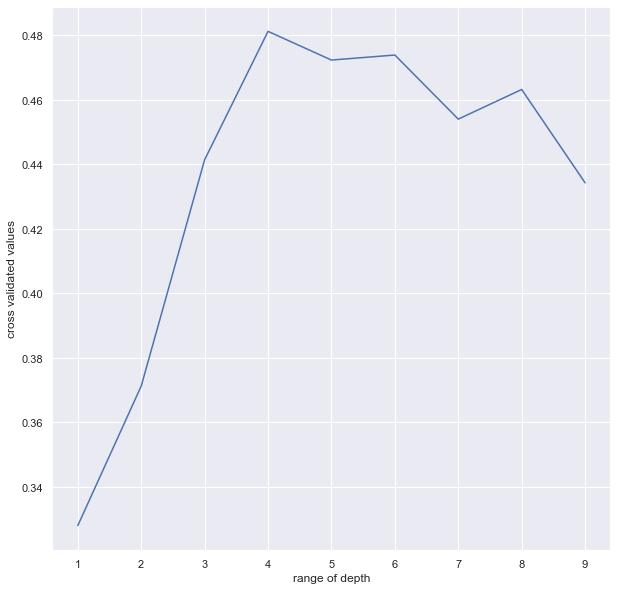

In [99]:
decision_tree_best_model(balanced['X_train'], balanced['y_train'])

In [100]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 6)

Confusion Matrix, without normalization
[[ 65  44  11  58  23]
 [ 20 140  24  44  14]
 [  0   3  19   9   0]
 [  7   4   1  18   4]
 [  4   4   0   0  17]]


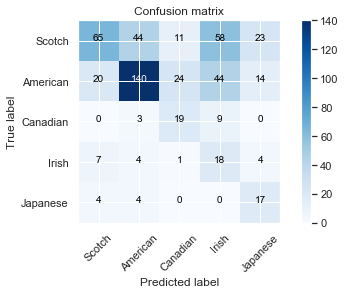

In [101]:
score_model(decision_tree_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [102]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### Random Forest

In [103]:
random_forest_model = random_forest(balanced['X_train'], balanced['y_train'], None, True)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Confusion Matrix, without normalization
[[ 99  24  12  37  29]
 [ 19 146  31  27  19]
 [  1   0  30   0   0]
 [  2   2   1  28   1]
 [  0   0   0   0  25]]


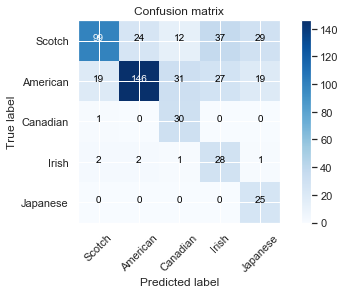

In [104]:
score_model(random_forest_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [105]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


In [106]:
# n_estimators = [10, 50, 100, 150, 200]
# max_features = ['auto', 'sqrt','log2', 14]
# max_depth =[2,5,7,10]
# min_samples_leaf=[1]
# min_samples_split=[2]
# bootstrap = [True, False]

n_estimators = [200]
max_features = ['auto']
max_depth =[10]
min_samples_leaf=[1]
min_samples_split=[2]
bootstrap = [True]

# Create the random grid
param_grid = {  'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split,
                'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [200], 'max_features': ['auto'], 'max_depth': [10], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [True]}


In [107]:
params = grid_search_cv(random_forest_model, features, target, param_grid, 4, 5)
print (params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [108]:
random_forest_model = random_forest(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[ 99  24  11  41  26]
 [ 12 149  30  29  22]
 [  1   0  30   0   0]
 [  2   2   1  28   1]
 [  0   0   0   0  25]]


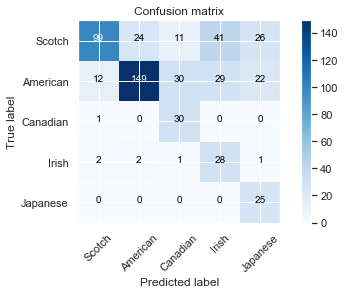

In [109]:
score_model(random_forest_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [110]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### Adaptive Boosting

In [111]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], None, True)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=42)


Confusion Matrix, without normalization
[[ 58  22  12  46  63]
 [ 37 104  49  31  21]
 [  1   0  28   2   0]
 [ 11   2   3  14   4]
 [  6   2   0   1  16]]


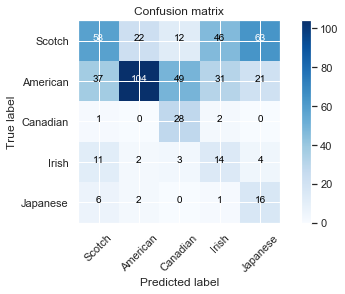

In [112]:
score_model(adaboost_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [113]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


In [114]:
# n_estimators = [500, 1000, 2000]
# learning_rate = [.001,0.01,.1]
# random_state = [42]

n_estimators = [500]
learning_rate = [.1]
random_state = [42]

param_grid = {  'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'random_state': random_state
             }
print(param_grid)

{'n_estimators': [500], 'learning_rate': [0.1], 'random_state': [42]}


In [115]:
params = grid_search_cv(adaboost_model, features, target, param_grid, 4, 5)
print (params)

{'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 42}


In [116]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[ 50  34  12  44  61]
 [ 29 125  34  36  18]
 [  1   2  25   3   0]
 [  6   2   5  14   7]
 [  3   3   0   1  18]]


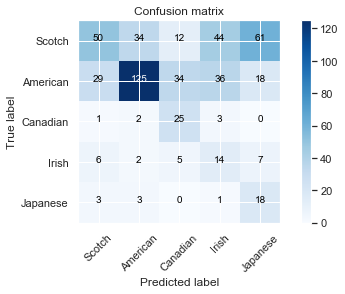

In [117]:
score_model(adaboost_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [118]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### Gradient Boost

In [119]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], None, True)

Confusion Matrix, without normalization
[[50 21 49 20 61]
 [29 84 77 20 32]
 [ 1  1 21  2  6]
 [ 5  0 12  6 11]
 [ 3  0  1  1 20]]


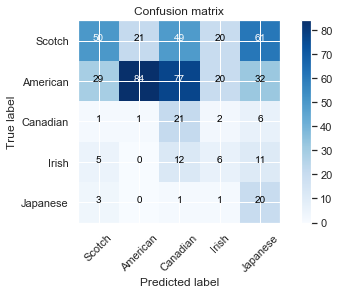

In [120]:
score_model(gradient_boost_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [121]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


In [122]:
# param_grid = {
#     "loss":["deviance", "exponential"],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "min_samples_split": [2],
#     "min_samples_leaf": [1],
#     "max_depth":[3,5,10],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[1.0],
#     "n_estimators":[50, 100, 200]
#     }

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.1],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[10],
    "max_features":["auto"],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
    "n_estimators":[100]
    }


# print(param_grid)

In [123]:
params = grid_search_cv(gradient_boost_model, features, target, param_grid, 4, 5)
print (params)

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [124]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[ 88  17  17  45  34]
 [ 27 115  36  47  17]
 [  0   1  29   1   0]
 [  4   0   2  27   1]
 [  0   0   0   0  25]]


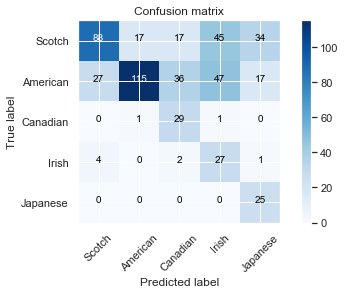

In [125]:
score_model(gradient_boost_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [126]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### XGBoost

In [127]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], None, True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Confusion Matrix, without normalization
[[ 81  27  14  49  30]
 [ 17 133  40  31  21]
 [  0   1  28   2   0]
 [  5   0   6  21   2]
 [  1   0   0   1  23]]


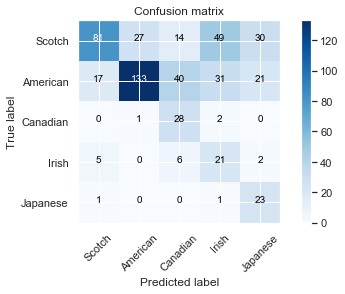

In [128]:
score_model(xgboost_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [129]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


In [130]:
# param_grid = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

param_grid = {
        'min_child_weight': [10],
        'gamma': [1.5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5]
        }

# print(param_grid)

In [131]:
params = grid_search_cv(xgboost_model, features, target, param_grid, 4, 5)
print (params)

{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0}


In [132]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[ 90  25  13  44  29]
 [ 25 128  38  33  18]
 [  0   0  26   4   1]
 [ 10   3   4  16   1]
 [  2   0   2   1  20]]


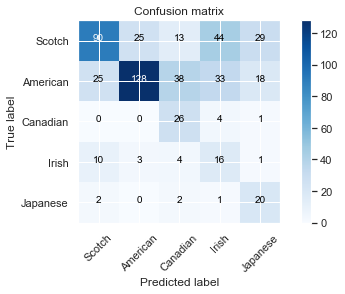

In [133]:
score_model(xgboost_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [134]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### Naive Bayes

In [135]:
naive_bayes_model = naive_bayes(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 70  47  26  41  17]
 [ 17 143  44  28  10]
 [  0   0  25   5   1]
 [  4   6   9  13   2]
 [  2   1   6   3  13]]


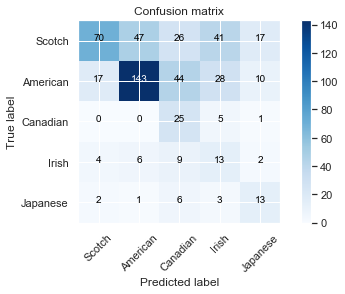

In [136]:
score_model(naive_bayes_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [137]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


## Model Fitting and Hyperparameter Tuning (with Random Oversampling)

In [138]:
split = data_split(features,target)

In [139]:
balanced = random_oversampling(split['X_train'], split['y_train'])

### Logistic Regression

In [140]:
logistic_regression_model = logistic_regression(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 77  27  16  52  29]
 [ 15 126  51  29  21]
 [  0   5  21   3   2]
 [  4   6   8  11   5]
 [  6   5   0   2  12]]


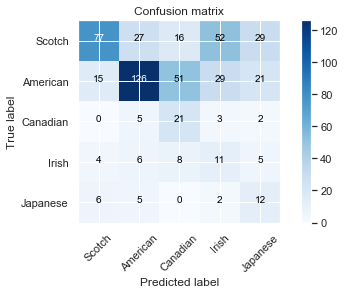

In [141]:
score_model(logistic_regression_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [142]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### K-Nearest Neighbor

In [143]:
scaled = scaler(balanced['X_train'], split['X_test'])

In [144]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[201   0   0   0   0]
 [  0 242   0   0   0]
 [  0   0  31   0   0]
 [  0   0   0  34   0]
 [  0   0   0   0  25]]


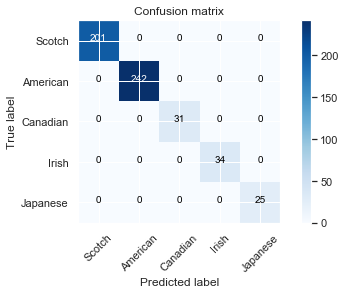

In [145]:
score_model(knn_model, "Random Oversampling", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [146]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


n = 1 - 1.0
n = 2 - 0.917392877274754
n = 3 - 0.8266922217400472
n = 4 - 0.801331316875498
n = 5 - 0.7687689488247536
n = 6 - 0.7426542679998472
n = 7 - 0.7090512621840453
n = 8 - 0.7003169974923467
n = 9 - 0.6880123104162914
n = 10 - 0.6662486544184386


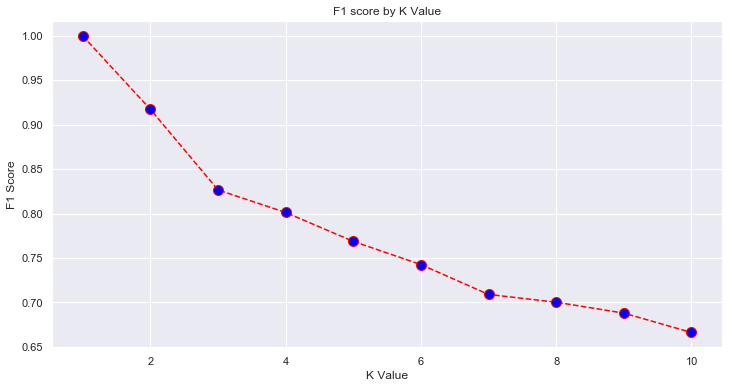

In [147]:
knn_best_model(scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [148]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[201   0   0   0   0]
 [  0 242   0   0   0]
 [  0   0  31   0   0]
 [  0   0   0  34   0]
 [  0   0   0   0  25]]


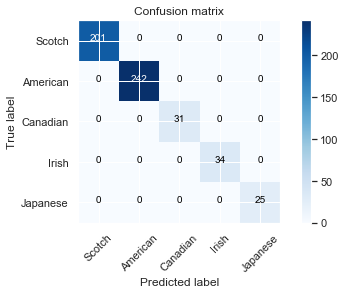

In [149]:
score_model(knn_model, "Random Oversampling", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [150]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### Decision Tree

In [151]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 5)

Confusion Matrix, without normalization
[[ 67  29  11  51  43]
 [ 11 142  37  27  25]
 [  0   6  20   3   2]
 [  2   3   4  13  12]
 [  1   2   0   0  22]]


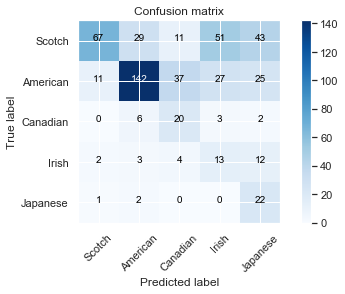

In [152]:
score_model(decision_tree_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [153]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


range(1, 10) - 0.3119127516778524
range(1, 10) - 0.3947986577181208
range(1, 10) - 0.4931208053691275
range(1, 10) - 0.5087248322147652
range(1, 10) - 0.55251677852349
range(1, 10) - 0.5840604026845637
range(1, 10) - 0.635234899328859
range(1, 10) - 0.6843959731543624
range(1, 10) - 0.7216442953020133


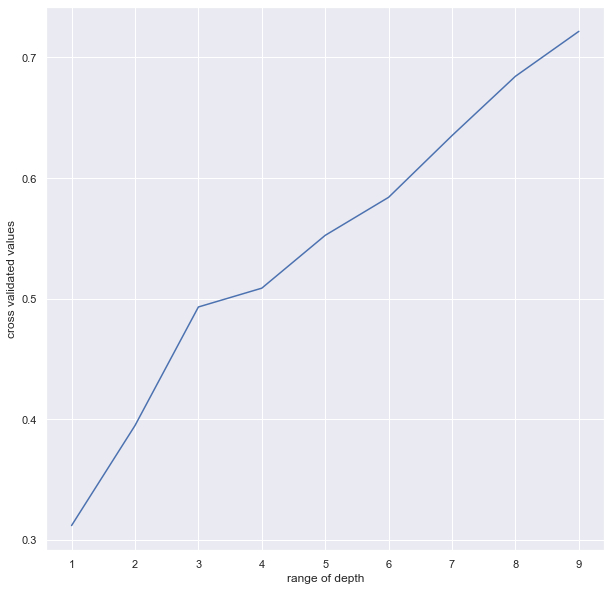

In [154]:
decision_tree_best_model(balanced['X_train'], balanced['y_train'])

In [155]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 6)

Confusion Matrix, without normalization
[[ 69  12  31  47  42]
 [  9 116  63  30  24]
 [  0   1  27   2   1]
 [  1   1   6  14  12]
 [  1   0   2   0  22]]


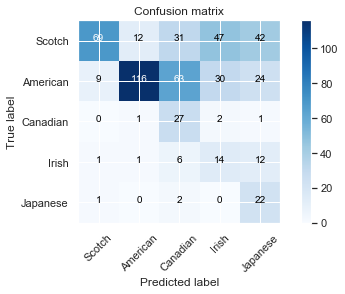

In [156]:
score_model(decision_tree_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [157]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### Random Forest

In [158]:
random_forest_model = random_forest(balanced['X_train'], balanced['y_train'], None, True)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Confusion Matrix, without normalization
[[201   0   0   0   0]
 [  0 242   0   0   0]
 [  0   0  31   0   0]
 [  0   0   0  34   0]
 [  0   0   0   0  25]]


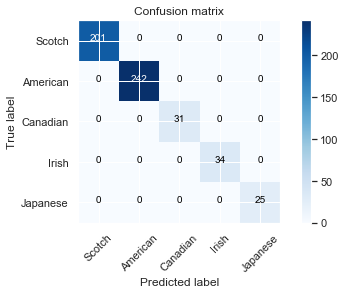

In [159]:
score_model(random_forest_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [160]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


In [161]:
# n_estimators = [10, 50, 100, 150, 200]
# max_features = ['auto', 'sqrt','log2', 14]
# max_depth =[2,5,7,10]
# min_samples_leaf=[1]
# min_samples_split=[2]
# bootstrap = [True, False]

n_estimators = [200]
max_features = ['auto']
max_depth =[10]
min_samples_leaf=[1]
min_samples_split=[2]
bootstrap = [True]

# Create the random grid
param_grid = {  'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split,
                'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [200], 'max_features': ['auto'], 'max_depth': [10], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [True]}


In [162]:
params = grid_search_cv(random_forest_model, features, target, param_grid, 4, 5)
print (params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [163]:
random_forest_model = random_forest(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[172   8   6  13   2]
 [  3 227   6   5   1]
 [  0   0  31   0   0]
 [  1   0   0  33   0]
 [  0   0   0   0  25]]


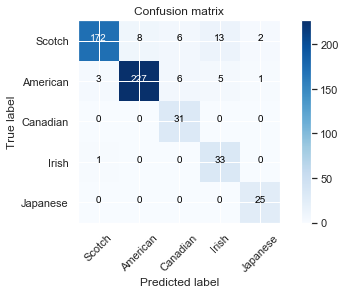

In [164]:
score_model(random_forest_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [165]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### Adaptive Boosting

In [166]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], None, True)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=42)


Confusion Matrix, without normalization
[[ 76  27  17  38  43]
 [ 29 108  68  17  20]
 [  1   0  28   2   0]
 [ 10   4   5  11   4]
 [  5   2   0   0  18]]


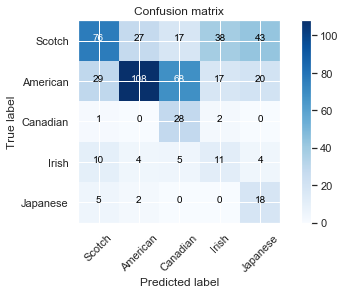

In [167]:
score_model(adaboost_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [168]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


In [169]:
# n_estimators = [500, 1000, 2000]
# learning_rate = [.001,0.01,.1]
# random_state = [42]

n_estimators = [500]
learning_rate = [.1]
random_state = [42]

param_grid = {  'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'random_state': random_state
             }
print(param_grid)

{'n_estimators': [500], 'learning_rate': [0.1], 'random_state': [42]}


In [170]:
params = grid_search_cv(adaboost_model, features, target, param_grid, 4, 5)
print (params)

{'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 42}


In [171]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[ 71  36  13  44  37]
 [ 26 134  48  20  14]
 [  2   1  25   3   0]
 [  9   3   3  14   5]
 [  4   2   0   1  18]]


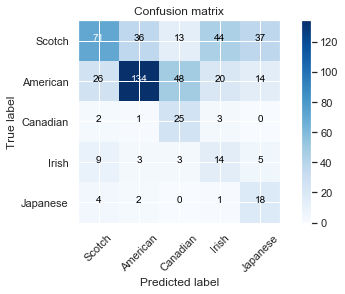

In [172]:
score_model(adaboost_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [173]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### Gradient Boost

In [174]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], None, True)

Confusion Matrix, without normalization
[[ 58  36  46  14  47]
 [ 22 132  61   8  19]
 [  0   3  21   1   6]
 [  2   3  15   3  11]
 [  4   2   1   0  18]]


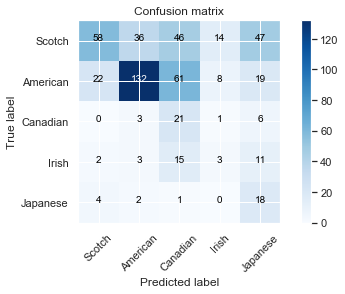

In [175]:
score_model(gradient_boost_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [176]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


In [177]:
# param_grid = {
#     "loss":["deviance", "exponential"],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "min_samples_split": [2],
#     "min_samples_leaf": [1],
#     "max_depth":[3,5,10],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[1.0],
#     "n_estimators":[50, 100, 200]
#     }

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.1],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[10],
    "max_features":["auto"],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
    "n_estimators":[100]
    }


# print(param_grid)

In [178]:
params = grid_search_cv(gradient_boost_model, features, target, param_grid, 4, 5)
print (params)

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [179]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[201   0   0   0   0]
 [  0 242   0   0   0]
 [  0   0  31   0   0]
 [  0   0   0  34   0]
 [  0   0   0   0  25]]


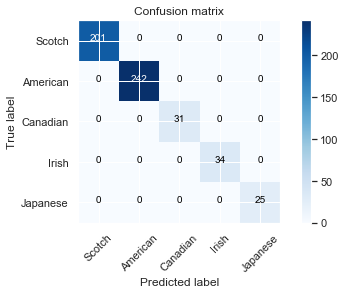

In [180]:
score_model(gradient_boost_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [181]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### XGBoost

In [182]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], None, True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Confusion Matrix, without normalization
[[113  20  11  39  18]
 [ 19 167  31  11  14]
 [  0   1  29   1   0]
 [  2   1   4  26   1]
 [  1   0   1   2  21]]


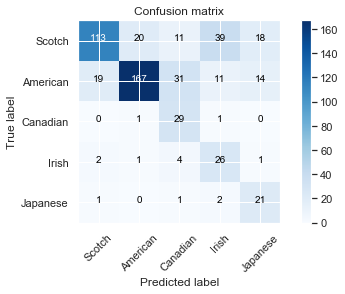

In [183]:
score_model(xgboost_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [184]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


In [185]:
# param_grid = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

param_grid = {
        'min_child_weight': [10],
        'gamma': [1.5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5]
        }

# print(param_grid)

In [186]:
params = grid_search_cv(xgboost_model, features, target, param_grid, 4, 5)
print (params)

{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0}


In [187]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[148  16   9  20   8]
 [ 20 196  15   9   2]
 [  0   0  31   0   0]
 [  1   2   1  30   0]
 [  0   0   0   0  25]]


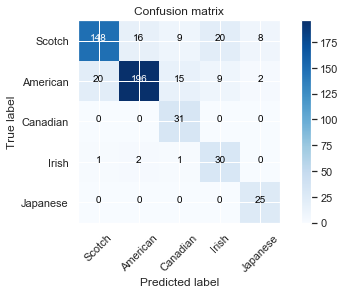

In [188]:
score_model(xgboost_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [189]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### Naive Bayes

In [190]:
naive_bayes_model = naive_bayes(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 64  39  28  55  15]
 [ 16 133  51  34   8]
 [  0   1  23   6   1]
 [  2   7   9  14   2]
 [  1   2   5   3  14]]


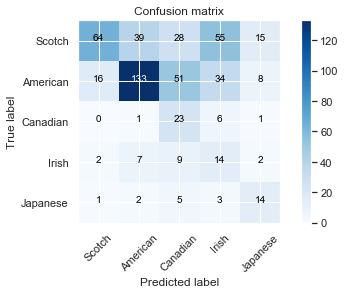

In [191]:
score_model(naive_bayes_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [192]:
split = data_split(features,target)

In [193]:
balanced = random_undersampling(split['X_train'], split['y_train'])

## Model Fitting and Hyperparameter Tuning (with Tomek Links)

In [194]:
split = data_split(features,target)

In [195]:
balanced = tomek_links(split['X_train'], split['y_train'])

### Logistic Regression

In [196]:
logistic_regression_model = logistic_regression(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[148  47   5   0   1]
 [ 36 201   5   0   0]
 [  6  16   9   0   0]
 [ 21  13   0   0   0]
 [ 18   6   0   0   1]]


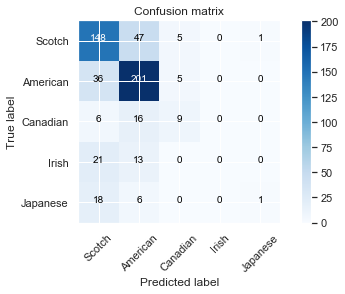

In [197]:
score_model(logistic_regression_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [198]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### K-Nearest Neighbor

In [199]:
scaled = scaler(balanced['X_train'], split['X_test'])

In [200]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[188   7   2   1   3]
 [  5 233   2   1   1]
 [  3   2  25   0   1]
 [  3   3   0  28   0]
 [  0   0   0   0  25]]


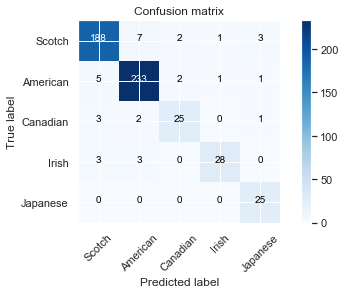

In [201]:
score_model(knn_model, "Tomek Links", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [202]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


n = 1 - 0.9358635793348068
n = 2 - 0.8007489051588086
n = 3 - 0.7947164338974321
n = 4 - 0.7880940452278642
n = 5 - 0.7658829244952559
n = 6 - 0.7397286448309759
n = 7 - 0.7408047177353566
n = 8 - 0.7106650776988405
n = 9 - 0.7115087732461506
n = 10 - 0.6966929972290163


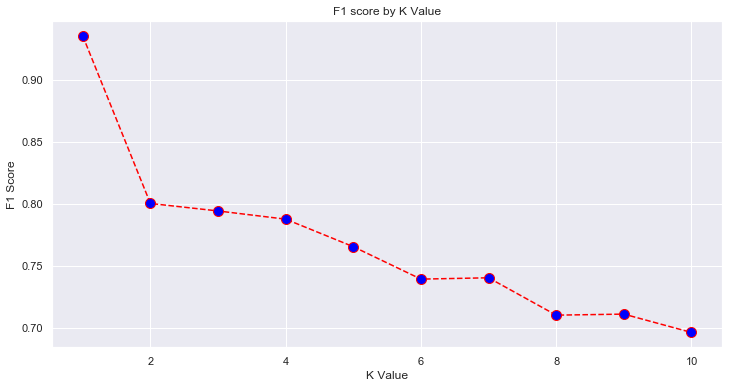

In [203]:
knn_best_model(scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [204]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[188   7   2   1   3]
 [  5 233   2   1   1]
 [  3   2  25   0   1]
 [  3   3   0  28   0]
 [  0   0   0   0  25]]


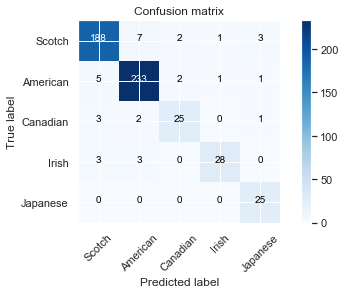

In [205]:
score_model(knn_model, "Tomek Links", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [206]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### Decision Tree

In [207]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 5)

Confusion Matrix, without normalization
[[161  31   8   0   1]
 [ 45 186  10   0   1]
 [  9   7  15   0   0]
 [ 21  12   1   0   0]
 [ 20   3   0   0   2]]


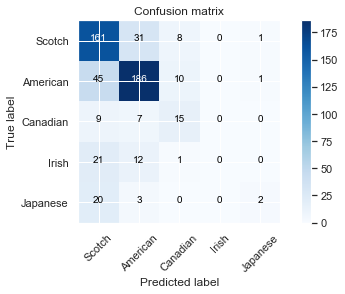

In [208]:
score_model(decision_tree_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [209]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


range(1, 10) - 0.5914246711342764
range(1, 10) - 0.5724391022231676
range(1, 10) - 0.6187621884196716
range(1, 10) - 0.6431798035669964
range(1, 10) - 0.6469613161720383
range(1, 10) - 0.6604208772116441
range(1, 10) - 0.670944580363791
range(1, 10) - 0.6696982590504555
range(1, 10) - 0.6595929511044925


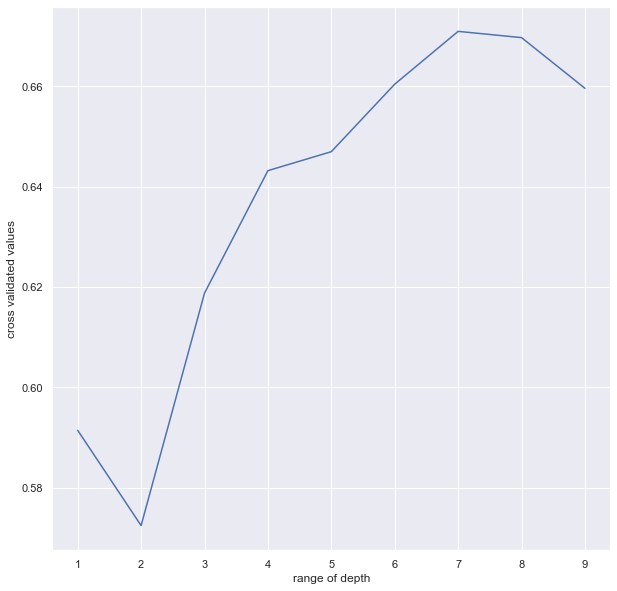

In [210]:
decision_tree_best_model(balanced['X_train'], balanced['y_train'])

In [211]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 6)

Confusion Matrix, without normalization
[[167  26   7   0   1]
 [ 48 189   5   0   0]
 [  8   8  15   0   0]
 [ 22  11   1   0   0]
 [ 17   5   0   0   3]]


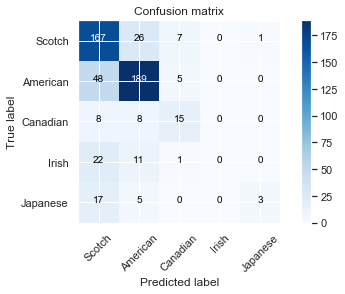

In [212]:
score_model(decision_tree_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [213]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### Random Forest

In [214]:
random_forest_model = random_forest(balanced['X_train'], balanced['y_train'], None, True)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Confusion Matrix, without normalization
[[194   6   1   0   0]
 [  4 238   0   0   0]
 [  1   4  25   1   0]
 [  4   3   0  27   0]
 [  0   0   0   0  25]]


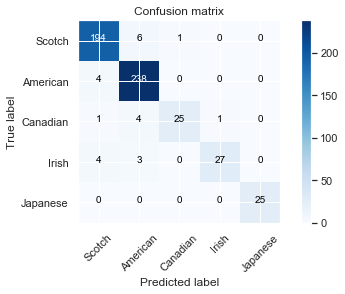

In [215]:
score_model(random_forest_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [216]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


In [217]:
# n_estimators = [10, 50, 100, 150, 200]
# max_features = ['auto', 'sqrt','log2', 14]
# max_depth =[2,5,7,10]
# min_samples_leaf=[1]
# min_samples_split=[2]
# bootstrap = [True, False]

n_estimators = [200]
max_features = ['auto']
max_depth =[10]
min_samples_leaf=[1]
min_samples_split=[2]
bootstrap = [True]

# Create the random grid
param_grid = {  'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split,
                'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [200], 'max_features': ['auto'], 'max_depth': [10], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [True]}


In [218]:
params = grid_search_cv(random_forest_model, features, target, param_grid, 4, 5)
print (params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [219]:
random_forest_model = random_forest(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[186  12   3   0   0]
 [ 14 227   1   0   0]
 [  4   6  21   0   0]
 [ 17   9   1   7   0]
 [ 10   1   0   0  14]]


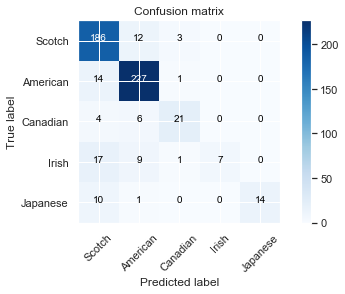

In [220]:
score_model(random_forest_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [221]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### Adaptive Boosting

In [222]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], None, True)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=42)


Confusion Matrix, without normalization
[[113  45   8  11  24]
 [ 33 164  30   6   9]
 [  5  10  15   1   0]
 [ 15   9   4   3   3]
 [  8   6   0   0  11]]


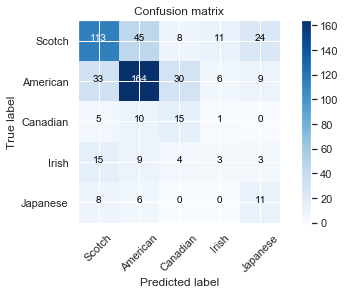

In [223]:
score_model(adaboost_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [224]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


In [225]:
# n_estimators = [500, 1000, 2000]
# learning_rate = [.001,0.01,.1]
# random_state = [42]

n_estimators = [500]
learning_rate = [.1]
random_state = [42]

param_grid = {  'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'random_state': random_state
             }
print(param_grid)

{'n_estimators': [500], 'learning_rate': [0.1], 'random_state': [42]}


In [226]:
params = grid_search_cv(adaboost_model, features, target, param_grid, 4, 5)
print (params)

{'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 42}


In [227]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[141  56   3   1   0]
 [ 34 199   8   0   1]
 [  5  14  12   0   0]
 [ 22  10   1   1   0]
 [ 18   4   0   0   3]]


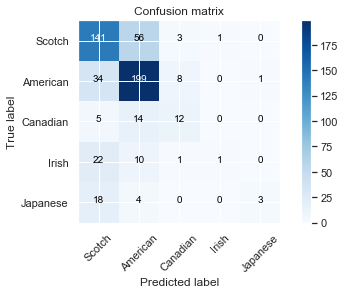

In [228]:
score_model(adaboost_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [229]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### Gradient Boost

In [230]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], None, True)

Confusion Matrix, without normalization
[[131  70   0   0   0]
 [ 83 159   0   0   0]
 [  7  24   0   0   0]
 [ 15  19   0   0   0]
 [ 23   2   0   0   0]]


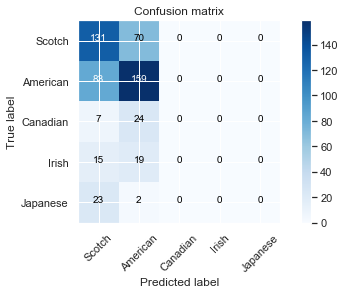

In [231]:
score_model(gradient_boost_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [232]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


In [233]:
# param_grid = {
#     "loss":["deviance", "exponential"],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "min_samples_split": [2],
#     "min_samples_leaf": [1],
#     "max_depth":[3,5,10],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[1.0],
#     "n_estimators":[50, 100, 200]
#     }

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.1],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[10],
    "max_features":["auto"],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
    "n_estimators":[100]
    }


# print(param_grid)

In [234]:
params = grid_search_cv(gradient_boost_model, features, target, param_grid, 4, 5)
print (params)

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [235]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[194   6   1   0   0]
 [  5 236   1   0   0]
 [  1   3  26   1   0]
 [  3   4   0  27   0]
 [  0   0   0   0  25]]


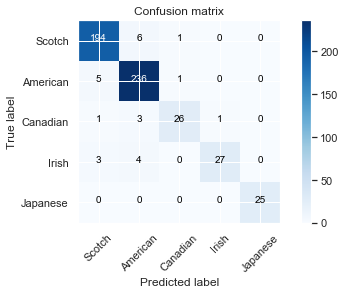

In [236]:
score_model(gradient_boost_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [237]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### XGBoost

In [238]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], None, True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Confusion Matrix, without normalization
[[162  35   3   0   1]
 [ 23 216   3   0   0]
 [  5   8  18   0   0]
 [ 20  14   0   0   0]
 [ 11   4   0   0  10]]


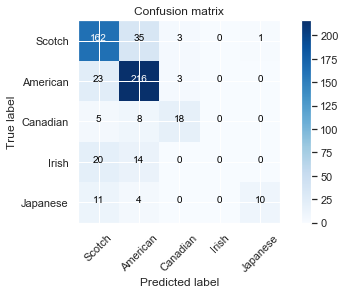

In [239]:
score_model(xgboost_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [240]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


In [241]:
# param_grid = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

param_grid = {
        'min_child_weight': [10],
        'gamma': [1.5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5]
        }

# print(param_grid)

In [242]:
params = grid_search_cv(xgboost_model, features, target, param_grid, 4, 5)
print (params)

{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0}


In [243]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[169  27   4   0   1]
 [ 21 218   3   0   0]
 [  5   8  18   0   0]
 [ 19  13   2   0   0]
 [  9   5   0   0  11]]


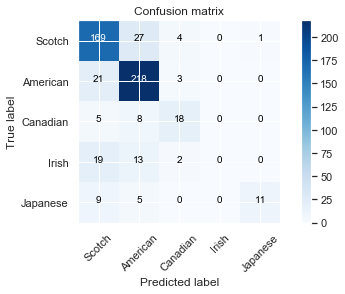

In [244]:
score_model(xgboost_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [245]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### Naive Bayes

In [246]:
naive_bayes_model = naive_bayes(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 86  87  11  15   2]
 [ 25 187  26   4   0]
 [  1   7  22   1   0]
 [  8  14   7   5   0]
 [  6   9   2   1   7]]


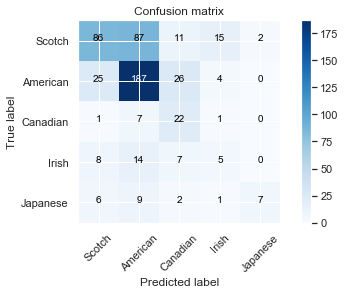

In [247]:
score_model(naive_bayes_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [248]:
split = data_split(features,target)

In [249]:
balanced = random_undersampling(split['X_train'], split['y_train'])

## Model Fitting and Hyperparameter Tuning (with Cluster Centroids)

In [250]:
split = data_split(features,target)

In [251]:
balanced = cluster_centroids(split['X_train'], split['y_train'])

### Logistic Regression

In [252]:
logistic_regression_model = logistic_regression(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 73  24  19  54  31]
 [  7 102  73  42  18]
 [  1   1  25   3   1]
 [  3   6   8  11   6]
 [  4   6   0   4  11]]


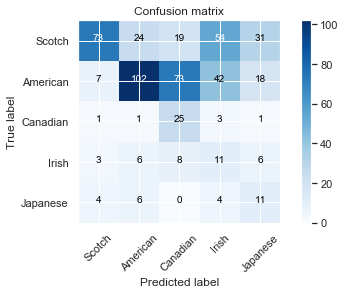

In [253]:
score_model(logistic_regression_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [254]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### K-Nearest Neighbor

In [255]:
scaled = scaler(balanced['X_train'], split['X_test'])

In [256]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[164  15   6  13   3]
 [ 22 167  23  17  13]
 [  0   0  31   0   0]
 [  0   0   0  34   0]
 [  0   0   0   0  25]]


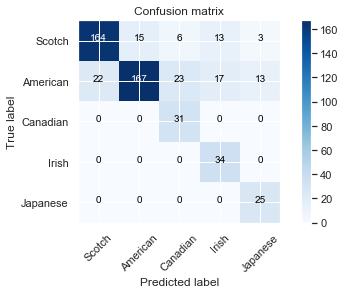

In [257]:
score_model(knn_model, "Cluster Centroids", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [258]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


n = 1 - 0.7966993891443749
n = 2 - 0.719991483807049
n = 3 - 0.6429326365589162
n = 4 - 0.6294962435084199
n = 5 - 0.6148372343888626
n = 6 - 0.6214536934943969
n = 7 - 0.6089171154594756
n = 8 - 0.5855598502562124
n = 9 - 0.5795991127902967
n = 10 - 0.5598587233696448


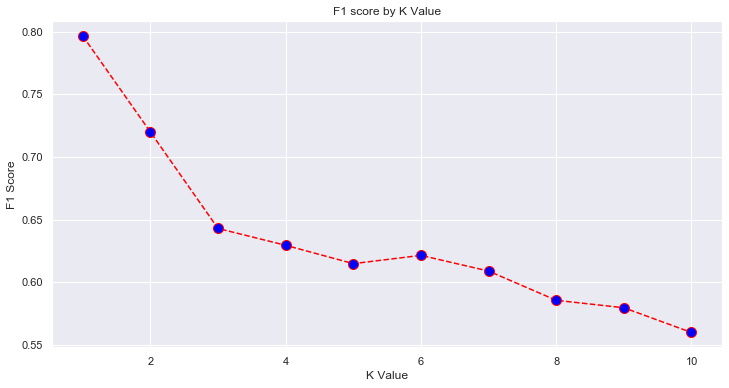

In [259]:
knn_best_model(scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [260]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[164  15   6  13   3]
 [ 22 167  23  17  13]
 [  0   0  31   0   0]
 [  0   0   0  34   0]
 [  0   0   0   0  25]]


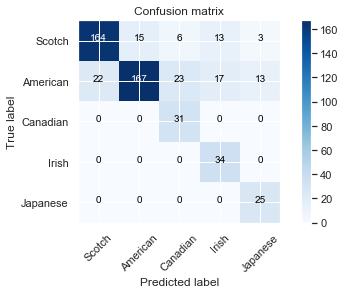

In [261]:
score_model(knn_model, "Cluster Centroids", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [262]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


### Decision Tree

In [263]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 5)

Confusion Matrix, without normalization
[[62  4  8 59 68]
 [18 35 68 55 66]
 [ 0  1 19  6  5]
 [ 2  0  5 13 14]
 [ 1  2  0  0 22]]


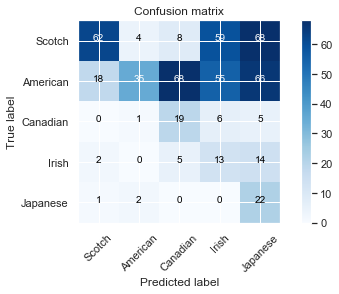

In [264]:
score_model(decision_tree_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [265]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
5,RandomForestClassifier,None,0.749,0.745,0.749,0.712,0.792
6,RandomForestClassifier,None,0.735,0.701,0.735,0.694,0.778
7,AdaBoostClassifier,None,0.610,0.612,0.610,0.608,0.709
8,AdaBoostClassifier,None,0.651,0.608,0.651,0.616,0.710
9,GradientBoostingClassifier,None,0.552,0.457,0.552,0.499,0.612


range(1, 10) - 0.34415584415584416
range(1, 10) - 0.4399350649350649
range(1, 10) - 0.4596753246753247
range(1, 10) - 0.4542207792207792
range(1, 10) - 0.4829545454545455
range(1, 10) - 0.492077922077922
range(1, 10) - 0.49198051948051946
range(1, 10) - 0.4794480519480519
range(1, 10) - 0.4720454545454545


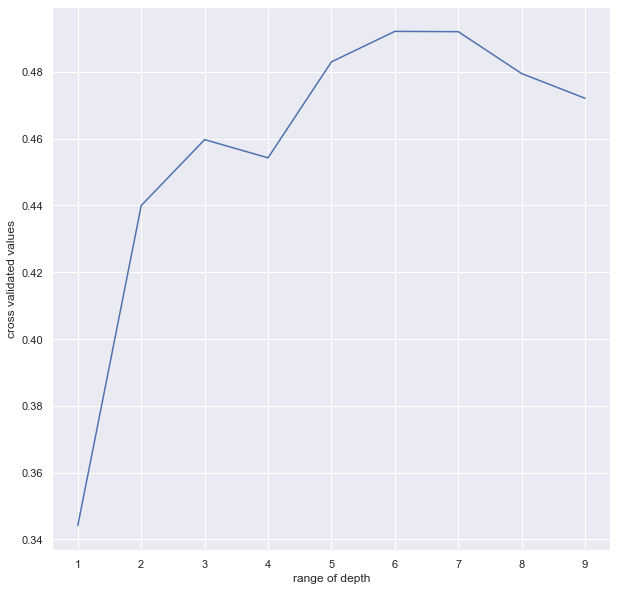

In [266]:
decision_tree_best_model(balanced['X_train'], balanced['y_train'])

In [267]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 6)

Confusion Matrix, without normalization
[[54 17 28 61 41]
 [18 42 96 65 21]
 [ 0  1 24  3  3]
 [ 2  1  7 13 11]
 [ 0  4  0  1 20]]


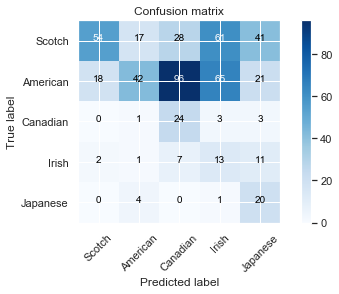

In [268]:
score_model(decision_tree_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [269]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
56,LogisticRegression,Cluster Centroids,0.417,0.671,0.417,0.473,0.656
57,KNeighborsClassifier,Cluster Centroids,0.790,0.842,0.790,0.797,0.866
58,KNeighborsClassifier,Cluster Centroids,0.790,0.842,0.790,0.797,0.866
59,DecisionTreeClassifier,Cluster Centroids,0.283,0.683,0.283,0.314,0.605


### Random Forest

In [270]:
random_forest_model = random_forest(balanced['X_train'], balanced['y_train'], None, True)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Confusion Matrix, without normalization
[[64 13 17 68 39]
 [ 4 67 82 61 28]
 [ 0  0 31  0  0]
 [ 0  0  4 27  3]
 [ 0  0  0  0 25]]


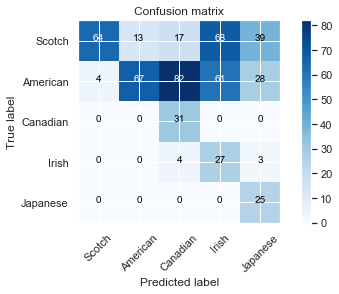

In [271]:
score_model(random_forest_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [272]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
57,KNeighborsClassifier,Cluster Centroids,0.790,0.842,0.790,0.797,0.866
58,KNeighborsClassifier,Cluster Centroids,0.790,0.842,0.790,0.797,0.866
59,DecisionTreeClassifier,Cluster Centroids,0.283,0.683,0.283,0.314,0.605
60,DecisionTreeClassifier,Cluster Centroids,0.287,0.593,0.287,0.312,0.595


In [273]:
# n_estimators = [10, 50, 100, 150, 200]
# max_features = ['auto', 'sqrt','log2', 14]
# max_depth =[2,5,7,10]
# min_samples_leaf=[1]
# min_samples_split=[2]
# bootstrap = [True, False]

n_estimators = [200]
max_features = ['auto']
max_depth =[10]
min_samples_leaf=[1]
min_samples_split=[2]
bootstrap = [True]

# Create the random grid
param_grid = {  'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split,
                'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [200], 'max_features': ['auto'], 'max_depth': [10], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [True]}


In [274]:
params = grid_search_cv(random_forest_model, features, target, param_grid, 4, 5)
print (params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [275]:
random_forest_model = random_forest(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[66 14 18 65 38]
 [ 4 67 78 69 24]
 [ 0  0 31  0  0]
 [ 0  1  4 25  4]
 [ 0  0  0  0 25]]


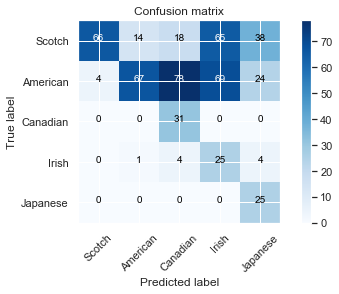

In [276]:
score_model(random_forest_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [277]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
58,KNeighborsClassifier,Cluster Centroids,0.790,0.842,0.790,0.797,0.866
59,DecisionTreeClassifier,Cluster Centroids,0.283,0.683,0.283,0.314,0.605
60,DecisionTreeClassifier,Cluster Centroids,0.287,0.593,0.287,0.312,0.595
61,RandomForestClassifier,Cluster Centroids,0.402,0.772,0.402,0.428,0.671


### Adaptive Boosting

In [278]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], None, True)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=42)


Confusion Matrix, without normalization
[[29 20 22 67 63]
 [ 9 47 88 59 39]
 [ 0  0 25  5  1]
 [ 3  1  7 15  8]
 [ 3  0  1  1 20]]


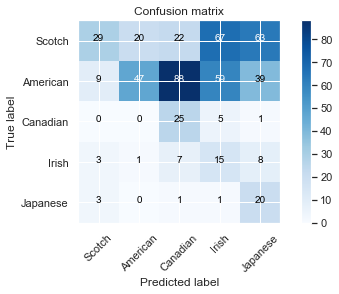

In [279]:
score_model(adaboost_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [280]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
59,DecisionTreeClassifier,Cluster Centroids,0.283,0.683,0.283,0.314,0.605
60,DecisionTreeClassifier,Cluster Centroids,0.287,0.593,0.287,0.312,0.595
61,RandomForestClassifier,Cluster Centroids,0.402,0.772,0.402,0.428,0.671
62,RandomForestClassifier,Cluster Centroids,0.402,0.763,0.402,0.430,0.669


In [281]:
# n_estimators = [500, 1000, 2000]
# learning_rate = [.001,0.01,.1]
# random_state = [42]

n_estimators = [500]
learning_rate = [.1]
random_state = [42]

param_grid = {  'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'random_state': random_state
             }
print(param_grid)

{'n_estimators': [500], 'learning_rate': [0.1], 'random_state': [42]}


In [282]:
params = grid_search_cv(adaboost_model, features, target, param_grid, 4, 5)
print (params)

{'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 42}


In [283]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[35 19 21 65 61]
 [ 6 62 82 56 36]
 [ 0  0 28  2  1]
 [ 2  1  5 17  9]
 [ 2  1  0  1 21]]


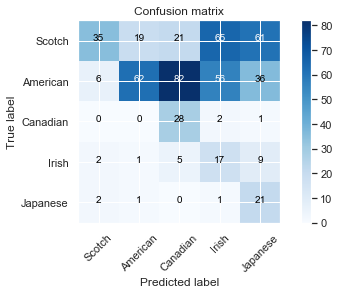

In [284]:
score_model(adaboost_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [285]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
60,DecisionTreeClassifier,Cluster Centroids,0.287,0.593,0.287,0.312,0.595
61,RandomForestClassifier,Cluster Centroids,0.402,0.772,0.402,0.428,0.671
62,RandomForestClassifier,Cluster Centroids,0.402,0.763,0.402,0.430,0.669
63,AdaBoostClassifier,Cluster Centroids,0.255,0.586,0.255,0.266,0.582


### Gradient Boost

In [286]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], None, True)

Confusion Matrix, without normalization
[[ 35  14  71  23  58]
 [  5  23 150  29  35]
 [  0   0  27   2   2]
 [  0   1  15   5  13]
 [  2   1   2   1  19]]


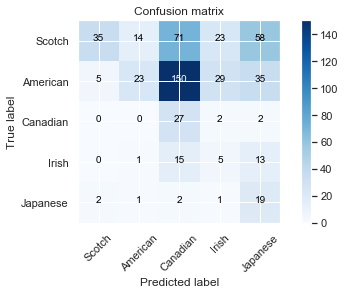

In [287]:
score_model(gradient_boost_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [288]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
61,RandomForestClassifier,Cluster Centroids,0.402,0.772,0.402,0.428,0.671
62,RandomForestClassifier,Cluster Centroids,0.402,0.763,0.402,0.430,0.669
63,AdaBoostClassifier,Cluster Centroids,0.255,0.586,0.255,0.266,0.582
64,AdaBoostClassifier,Cluster Centroids,0.306,0.660,0.306,0.325,0.612


In [289]:
# param_grid = {
#     "loss":["deviance", "exponential"],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "min_samples_split": [2],
#     "min_samples_leaf": [1],
#     "max_depth":[3,5,10],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[1.0],
#     "n_estimators":[50, 100, 200]
#     }

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.1],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[10],
    "max_features":["auto"],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
    "n_estimators":[100]
    }


# print(param_grid)

In [290]:
params = grid_search_cv(gradient_boost_model, features, target, param_grid, 4, 5)
print (params)

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [291]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[43 15 37 68 38]
 [ 5 51 81 63 42]
 [ 0  0 30  1  0]
 [ 2  1  3 26  2]
 [ 0  0  0  0 25]]


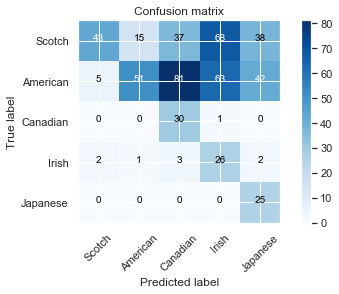

In [292]:
score_model(gradient_boost_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [293]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
62,RandomForestClassifier,Cluster Centroids,0.402,0.763,0.402,0.430,0.669
63,AdaBoostClassifier,Cluster Centroids,0.255,0.586,0.255,0.266,0.582
64,AdaBoostClassifier,Cluster Centroids,0.306,0.660,0.306,0.325,0.612
65,GradientBoostingClassifier,Cluster Centroids,0.205,0.600,0.205,0.212,0.564


### XGBoost

In [294]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], None, True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Confusion Matrix, without normalization
[[56 15 13 72 45]
 [ 9 47 94 59 33]
 [ 0  0 31  0  0]
 [ 2  0  5 22  5]
 [ 0  0  0  1 24]]


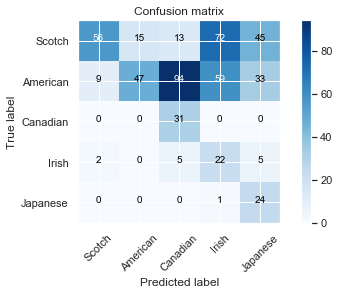

In [295]:
score_model(xgboost_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [296]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
63,AdaBoostClassifier,Cluster Centroids,0.255,0.586,0.255,0.266,0.582
64,AdaBoostClassifier,Cluster Centroids,0.306,0.660,0.306,0.325,0.612
65,GradientBoostingClassifier,Cluster Centroids,0.205,0.600,0.205,0.212,0.564
66,GradientBoostingClassifier,Cluster Centroids,0.328,0.703,0.328,0.333,0.628


In [297]:
# param_grid = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

param_grid = {
        'min_child_weight': [10],
        'gamma': [1.5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5]
        }

# print(param_grid)

In [298]:
params = grid_search_cv(xgboost_model, features, target, param_grid, 4, 5)
print (params)

{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0}


In [299]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[57 15 14 71 44]
 [ 7 59 80 66 30]
 [ 0  0 29  2  0]
 [ 2  2  5 21  4]
 [ 0  0  0  1 24]]


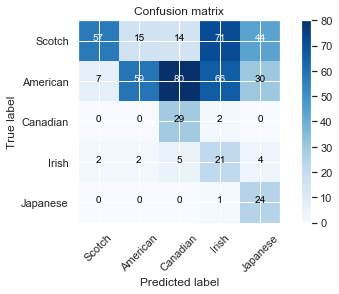

In [300]:
score_model(xgboost_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [301]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
64,AdaBoostClassifier,Cluster Centroids,0.306,0.660,0.306,0.325,0.612
65,GradientBoostingClassifier,Cluster Centroids,0.205,0.600,0.205,0.212,0.564
66,GradientBoostingClassifier,Cluster Centroids,0.328,0.703,0.328,0.333,0.628
67,XGBClassifier,Cluster Centroids,0.338,0.692,0.338,0.351,0.632


### Naive Bayes

In [302]:
naive_bayes_model = naive_bayes(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 52  25  44  57  23]
 [  7 101  96  29   9]
 [  0   0  26   4   1]
 [  2   5  13  11   3]
 [  2   0   8   1  14]]


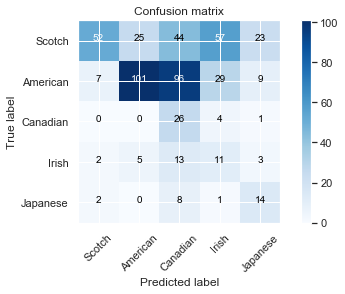

In [303]:
score_model(naive_bayes_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

## Model Fitting and Hyperparameter Tuning (with SMOTE)

In [304]:
split = data_split(features,target)

In [305]:
balanced = smote(split['X_train'], split['y_train'])

### Logistic Regression

In [306]:
logistic_regression_model = logistic_regression(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 86  27  19  43  26]
 [ 14 129  51  27  21]
 [  0   3  22   4   2]
 [  5   6   8  10   5]
 [  7   5   0   2  11]]


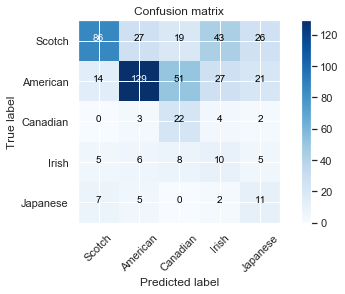

In [307]:
score_model(logistic_regression_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [308]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
66,GradientBoostingClassifier,Cluster Centroids,0.328,0.703,0.328,0.333,0.628
67,XGBClassifier,Cluster Centroids,0.338,0.692,0.338,0.351,0.632
68,XGBClassifier,Cluster Centroids,0.356,0.711,0.356,0.382,0.642
69,GaussianNB,Cluster Centroids,0.383,0.689,0.383,0.436,0.645


### K-Nearest Neighbor

In [309]:
scaled = scaler(balanced['X_train'], split['X_test'])

In [310]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[201   0   0   0   0]
 [  0 242   0   0   0]
 [  0   0  31   0   0]
 [  0   0   0  34   0]
 [  0   0   0   0  25]]


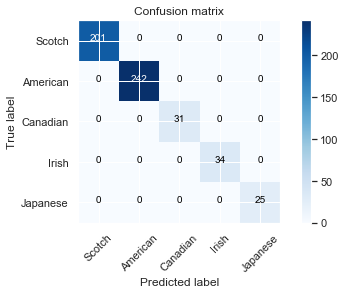

In [311]:
score_model(knn_model, "SMOTE", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [312]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
67,XGBClassifier,Cluster Centroids,0.338,0.692,0.338,0.351,0.632
68,XGBClassifier,Cluster Centroids,0.356,0.711,0.356,0.382,0.642
69,GaussianNB,Cluster Centroids,0.383,0.689,0.383,0.436,0.645
70,LogisticRegression,SMOTE,0.484,0.662,0.484,0.533,0.683


n = 1 - 1.0
n = 2 - 0.9230769230769231
n = 3 - 0.8172327632319946
n = 4 - 0.8128853232684892
n = 5 - 0.742525865552251
n = 6 - 0.7463369365584229
n = 7 - 0.7222501295501319
n = 8 - 0.7235169429798631
n = 9 - 0.6985726119421942
n = 10 - 0.6835684710421539


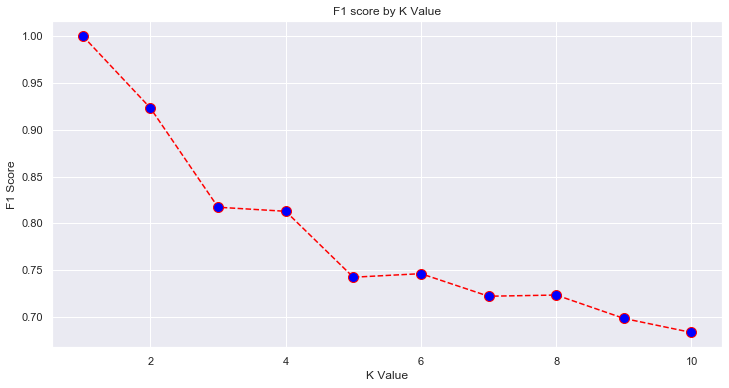

In [313]:
knn_best_model(scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [314]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[201   0   0   0   0]
 [  0 242   0   0   0]
 [  0   0  31   0   0]
 [  0   0   0  34   0]
 [  0   0   0   0  25]]


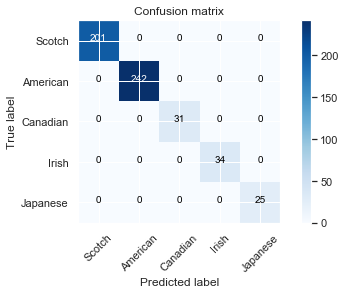

In [315]:
score_model(knn_model, "SMOTE", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [316]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
68,XGBClassifier,Cluster Centroids,0.356,0.711,0.356,0.382,0.642
69,GaussianNB,Cluster Centroids,0.383,0.689,0.383,0.436,0.645
70,LogisticRegression,SMOTE,0.484,0.662,0.484,0.533,0.683
71,KNeighborsClassifier,SMOTE,1.000,1.000,1.000,1.000,1.000


### Decision Tree

In [317]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 5)

Confusion Matrix, without normalization
[[ 88  50   4  45  14]
 [ 14 152  24  26  26]
 [  0  10  17   2   2]
 [  7   8   4  12   3]
 [  4   2   0   5  14]]


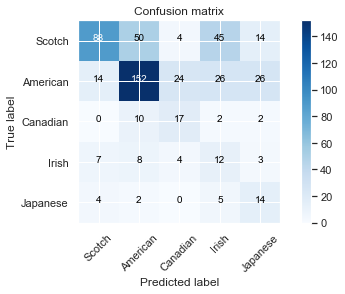

In [318]:
score_model(decision_tree_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [319]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
69,GaussianNB,Cluster Centroids,0.383,0.689,0.383,0.436,0.645
70,LogisticRegression,SMOTE,0.484,0.662,0.484,0.533,0.683
71,KNeighborsClassifier,SMOTE,1.000,1.000,1.000,1.000,1.000
72,KNeighborsClassifier,SMOTE,1.000,1.000,1.000,1.000,1.000


range(1, 10) - 0.3295302013422819
range(1, 10) - 0.3947986577181208
range(1, 10) - 0.4728187919463087
range(1, 10) - 0.5295302013422819
range(1, 10) - 0.5669463087248323
range(1, 10) - 0.5890939597315437
range(1, 10) - 0.6293624161073825
range(1, 10) - 0.6604026845637583
range(1, 10) - 0.6758389261744966


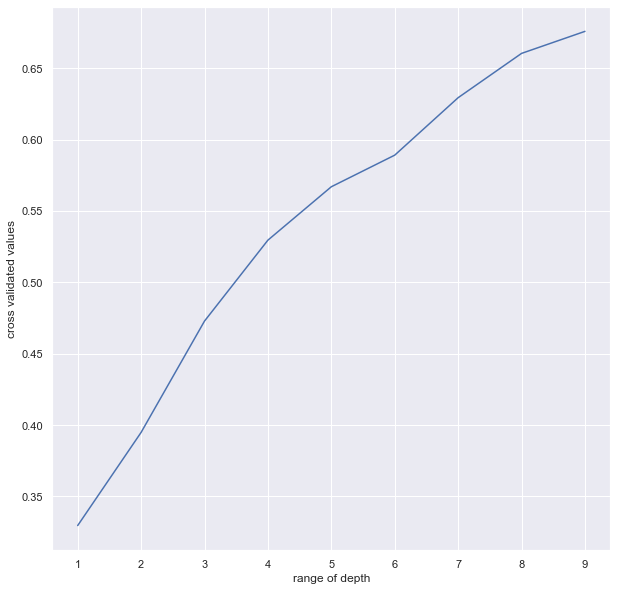

In [320]:
decision_tree_best_model(balanced['X_train'], balanced['y_train'])

In [321]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 6)

Confusion Matrix, without normalization
[[ 99  56   8  31   7]
 [ 14 180  29  18   1]
 [  0   8  22   1   0]
 [  6   9   4  13   2]
 [  3   5   1   5  11]]


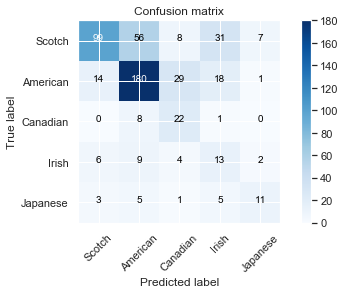

In [322]:
score_model(decision_tree_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [323]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
70,LogisticRegression,SMOTE,0.484,0.662,0.484,0.533,0.683
71,KNeighborsClassifier,SMOTE,1.000,1.000,1.000,1.000,1.000
72,KNeighborsClassifier,SMOTE,1.000,1.000,1.000,1.000,1.000
73,DecisionTreeClassifier,SMOTE,0.531,0.644,0.531,0.562,0.688


### Random Forest

In [324]:
random_forest_model = random_forest(balanced['X_train'], balanced['y_train'], None, True)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Confusion Matrix, without normalization
[[201   0   0   0   0]
 [  0 242   0   0   0]
 [  0   0  31   0   0]
 [  0   0   0  34   0]
 [  0   0   0   0  25]]


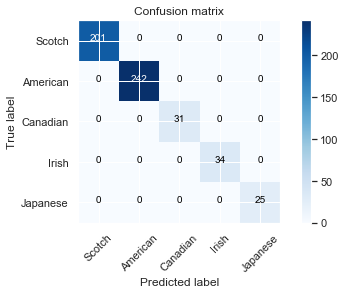

In [325]:
score_model(random_forest_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [326]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
71,KNeighborsClassifier,SMOTE,1.000,1.000,1.000,1.000,1.000
72,KNeighborsClassifier,SMOTE,1.000,1.000,1.000,1.000,1.000
73,DecisionTreeClassifier,SMOTE,0.531,0.644,0.531,0.562,0.688
74,DecisionTreeClassifier,SMOTE,0.610,0.680,0.610,0.624,0.725


In [327]:
# n_estimators = [10, 50, 100, 150, 200]
# max_features = ['auto', 'sqrt','log2', 14]
# max_depth =[2,5,7,10]
# min_samples_leaf=[1]
# min_samples_split=[2]
# bootstrap = [True, False]

n_estimators = [200]
max_features = ['auto']
max_depth =[10]
min_samples_leaf=[1]
min_samples_split=[2]
bootstrap = [True]

# Create the random grid
param_grid = {  'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split,
                'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [200], 'max_features': ['auto'], 'max_depth': [10], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [True]}


In [328]:
params = grid_search_cv(random_forest_model, features, target, param_grid, 4, 5)
print (params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [329]:
random_forest_model = random_forest(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[177   8   5   9   2]
 [  5 228   4   4   1]
 [  0   1  29   1   0]
 [  2   0   0  32   0]
 [  0   0   0   1  24]]


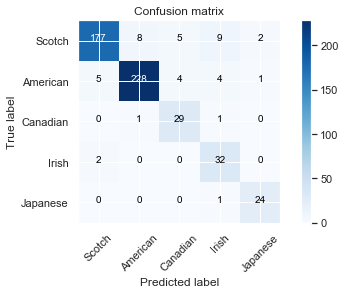

In [330]:
score_model(random_forest_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [331]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
72,KNeighborsClassifier,SMOTE,1.000,1.000,1.000,1.000,1.000
73,DecisionTreeClassifier,SMOTE,0.531,0.644,0.531,0.562,0.688
74,DecisionTreeClassifier,SMOTE,0.610,0.680,0.610,0.624,0.725
75,RandomForestClassifier,SMOTE,1.000,1.000,1.000,1.000,1.000


### Adaptive Boosting

In [332]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], None, True)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=42)


Confusion Matrix, without normalization
[[ 77  40  15  28  41]
 [ 29 117  62  16  18]
 [  2   2  23   4   0]
 [ 10   2   6  11   5]
 [  5   3   0   0  17]]


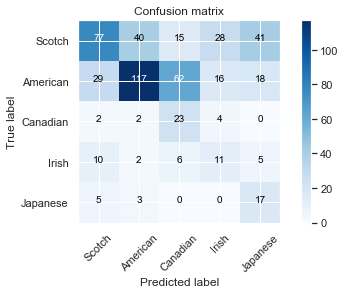

In [333]:
score_model(adaboost_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [334]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
73,DecisionTreeClassifier,SMOTE,0.531,0.644,0.531,0.562,0.688
74,DecisionTreeClassifier,SMOTE,0.610,0.680,0.610,0.624,0.725
75,RandomForestClassifier,SMOTE,1.000,1.000,1.000,1.000,1.000
76,RandomForestClassifier,SMOTE,0.919,0.929,0.919,0.922,0.947


In [335]:
# n_estimators = [500, 1000, 2000]
# learning_rate = [.001,0.01,.1]
# random_state = [42]

n_estimators = [500]
learning_rate = [.1]
random_state = [42]

param_grid = {  'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'random_state': random_state
             }
print(param_grid)

{'n_estimators': [500], 'learning_rate': [0.1], 'random_state': [42]}


In [336]:
params = grid_search_cv(adaboost_model, features, target, param_grid, 4, 5)
print (params)

{'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 42}


In [337]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[ 81  35  12  43  30]
 [ 30 145  40  17  10]
 [  3   3  22   3   0]
 [ 10   4   5  10   5]
 [  6   3   0   0  16]]


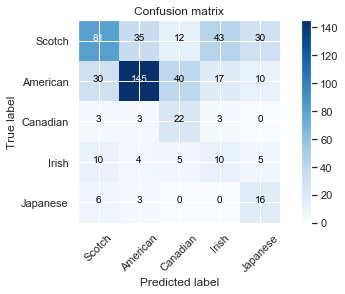

In [338]:
score_model(adaboost_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [339]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
74,DecisionTreeClassifier,SMOTE,0.610,0.680,0.610,0.624,0.725
75,RandomForestClassifier,SMOTE,1.000,1.000,1.000,1.000,1.000
76,RandomForestClassifier,SMOTE,0.919,0.929,0.919,0.922,0.947
77,AdaBoostClassifier,SMOTE,0.460,0.594,0.460,0.491,0.656


### Gradient Boost

In [340]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], None, True)

Confusion Matrix, without normalization
[[60 17 55 13 56]
 [26 83 91 11 31]
 [ 0  1 23  1  6]
 [ 3  0 15  3 13]
 [ 4  0  1  0 20]]


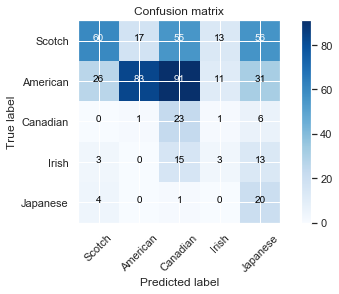

In [341]:
score_model(gradient_boost_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [342]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
75,RandomForestClassifier,SMOTE,1.000,1.000,1.000,1.000,1.000
76,RandomForestClassifier,SMOTE,0.919,0.929,0.919,0.922,0.947
77,AdaBoostClassifier,SMOTE,0.460,0.594,0.460,0.491,0.656
78,AdaBoostClassifier,SMOTE,0.514,0.619,0.514,0.542,0.685


In [343]:
# param_grid = {
#     "loss":["deviance", "exponential"],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "min_samples_split": [2],
#     "min_samples_leaf": [1],
#     "max_depth":[3,5,10],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[1.0],
#     "n_estimators":[50, 100, 200]
#     }

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.1],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[10],
    "max_features":["auto"],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
    "n_estimators":[100]
    }


# print(param_grid)

In [344]:
params = grid_search_cv(gradient_boost_model, features, target, param_grid, 4, 5)
print (params)

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [345]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[201   0   0   0   0]
 [  0 242   0   0   0]
 [  0   0  31   0   0]
 [  0   0   0  34   0]
 [  0   0   0   0  25]]


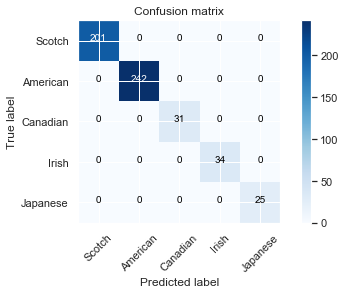

In [346]:
score_model(gradient_boost_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [347]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
76,RandomForestClassifier,SMOTE,0.919,0.929,0.919,0.922,0.947
77,AdaBoostClassifier,SMOTE,0.460,0.594,0.460,0.491,0.656
78,AdaBoostClassifier,SMOTE,0.514,0.619,0.514,0.542,0.685
79,GradientBoostingClassifier,SMOTE,0.355,0.638,0.355,0.405,0.629


### XGBoost

In [348]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], None, True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Confusion Matrix, without normalization
[[137  24   8  22  10]
 [ 17 192  15   9   9]
 [  1   5  23   2   0]
 [ 12   5   2  15   0]
 [  4   2   0   1  18]]


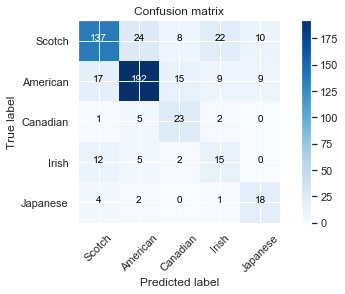

In [349]:
score_model(xgboost_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [350]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
77,AdaBoostClassifier,SMOTE,0.460,0.594,0.460,0.491,0.656
78,AdaBoostClassifier,SMOTE,0.514,0.619,0.514,0.542,0.685
79,GradientBoostingClassifier,SMOTE,0.355,0.638,0.355,0.405,0.629
80,GradientBoostingClassifier,SMOTE,1.000,1.000,1.000,1.000,1.000


In [351]:
# param_grid = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

param_grid = {
        'min_child_weight': [10],
        'gamma': [1.5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5]
        }

# print(param_grid)

In [352]:
params = grid_search_cv(xgboost_model, features, target, param_grid, 4, 5)
print (params)

{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0}


In [353]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[164  18   7   7   5]
 [ 15 207   9   9   2]
 [  1   5  24   1   0]
 [  8   1   2  23   0]
 [  3   1   0   1  20]]


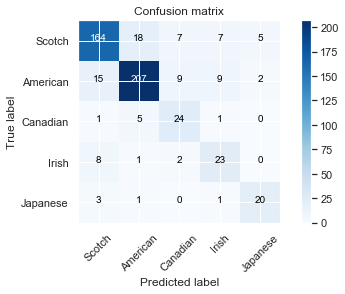

In [354]:
score_model(xgboost_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [355]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
78,AdaBoostClassifier,SMOTE,0.514,0.619,0.514,0.542,0.685
79,GradientBoostingClassifier,SMOTE,0.355,0.638,0.355,0.405,0.629
80,GradientBoostingClassifier,SMOTE,1.000,1.000,1.000,1.000,1.000
81,XGBClassifier,SMOTE,0.722,0.755,0.722,0.733,0.809


### Naive Bayes

In [356]:
naive_bayes_model = naive_bayes(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 68  40  18  59  16]
 [ 21 135  37  40   9]
 [  0   2  22   6   1]
 [  3   7   8  14   2]
 [  3   1   3   6  12]]


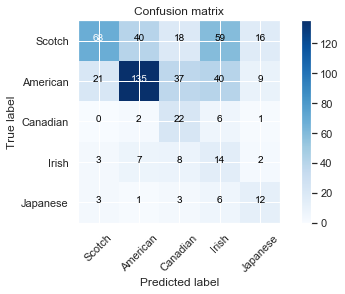

In [357]:
score_model(naive_bayes_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [358]:
split = data_split(features,target)

In [359]:
balanced = random_undersampling(split['X_train'], split['y_train'])

## Model Fitting and Hyperparameter Tuning (with Cluster Centroids)

In [360]:
split = data_split(features,target)

In [361]:
balanced = smote_tomek(split['X_train'], split['y_train'])

### Logistic Regression

In [362]:
logistic_regression_model = logistic_regression(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 81  27  15  47  31]
 [ 14 126  51  29  22]
 [  0   2  23   4   2]
 [  4   6   6  12   6]
 [  5   5   0   3  12]]


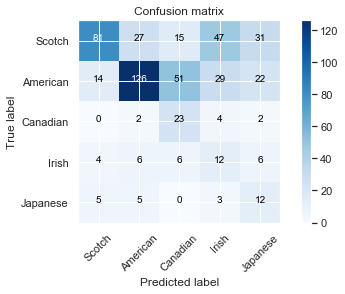

In [363]:
score_model(logistic_regression_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [364]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
80,GradientBoostingClassifier,SMOTE,1.000,1.000,1.000,1.000,1.000
81,XGBClassifier,SMOTE,0.722,0.755,0.722,0.733,0.809
82,XGBClassifier,SMOTE,0.822,0.833,0.822,0.826,0.874
83,GaussianNB,SMOTE,0.471,0.637,0.471,0.510,0.669


### K-Nearest Neighbor

In [365]:
scaled = scaler(balanced['X_train'], split['X_test'])

In [366]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[198   1   0   2   0]
 [  2 239   0   0   1]
 [  0   0  31   0   0]
 [  0   0   0  34   0]
 [  0   0   0   0  25]]


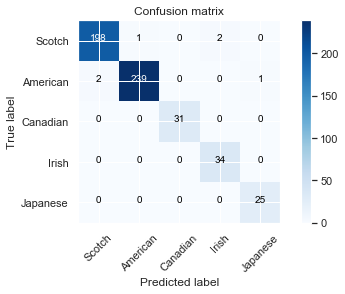

In [367]:
score_model(knn_model, "SMOTE Tomek", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [368]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
81,XGBClassifier,SMOTE,0.722,0.755,0.722,0.733,0.809
82,XGBClassifier,SMOTE,0.822,0.833,0.822,0.826,0.874
83,GaussianNB,SMOTE,0.471,0.637,0.471,0.510,0.669
84,LogisticRegression,SMOTE Tomek,0.477,0.668,0.477,0.525,0.682


n = 1 - 0.9887876963996027
n = 2 - 0.9324359371002072
n = 3 - 0.8094481905117286
n = 4 - 0.7946128648896689
n = 5 - 0.7444233314162937
n = 6 - 0.7390560737862469
n = 7 - 0.7220751815817259
n = 8 - 0.7040134303070461
n = 9 - 0.6771136514130293
n = 10 - 0.6643191076118261


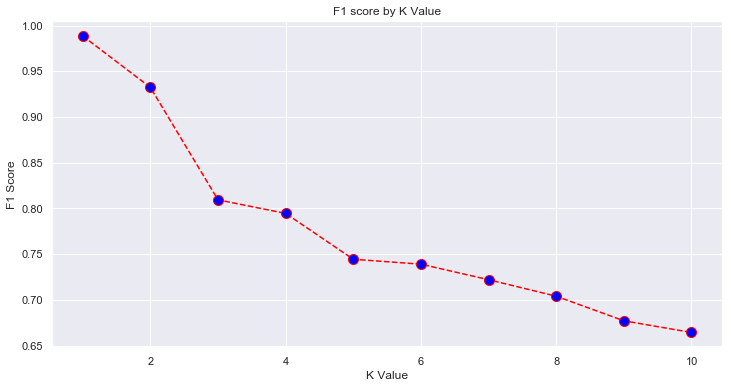

In [369]:
knn_best_model(scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [370]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[198   1   0   2   0]
 [  2 239   0   0   1]
 [  0   0  31   0   0]
 [  0   0   0  34   0]
 [  0   0   0   0  25]]


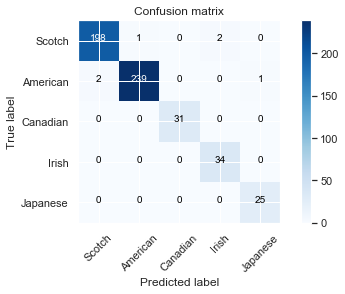

In [371]:
score_model(knn_model, "SMOTE Tomek", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [372]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
82,XGBClassifier,SMOTE,0.822,0.833,0.822,0.826,0.874
83,GaussianNB,SMOTE,0.471,0.637,0.471,0.510,0.669
84,LogisticRegression,SMOTE Tomek,0.477,0.668,0.477,0.525,0.682
85,KNeighborsClassifier,SMOTE Tomek,0.989,0.989,0.989,0.989,0.992


### Decision Tree

In [373]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 5)

Confusion Matrix, without normalization
[[ 63  52  14  55  17]
 [ 14 141  25  46  16]
 [  0   5  22   1   3]
 [  0  10   2  21   1]
 [  2   2   0   6  15]]


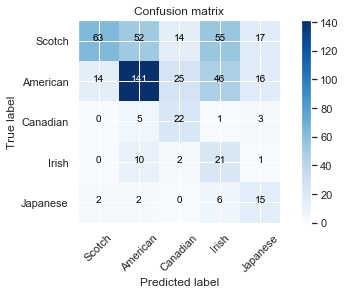

In [374]:
score_model(decision_tree_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [375]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
83,GaussianNB,SMOTE,0.471,0.637,0.471,0.510,0.669
84,LogisticRegression,SMOTE Tomek,0.477,0.668,0.477,0.525,0.682
85,KNeighborsClassifier,SMOTE Tomek,0.989,0.989,0.989,0.989,0.992
86,KNeighborsClassifier,SMOTE Tomek,0.989,0.989,0.989,0.989,0.992


range(1, 10) - 0.3446751613763052
range(1, 10) - 0.41135283755751023
range(1, 10) - 0.49880633684478914
range(1, 10) - 0.5358999988411037
range(1, 10) - 0.5750217293050099
range(1, 10) - 0.6195908516728668
range(1, 10) - 0.6498742597550093
range(1, 10) - 0.6830525907126054
range(1, 10) - 0.7078935321999327


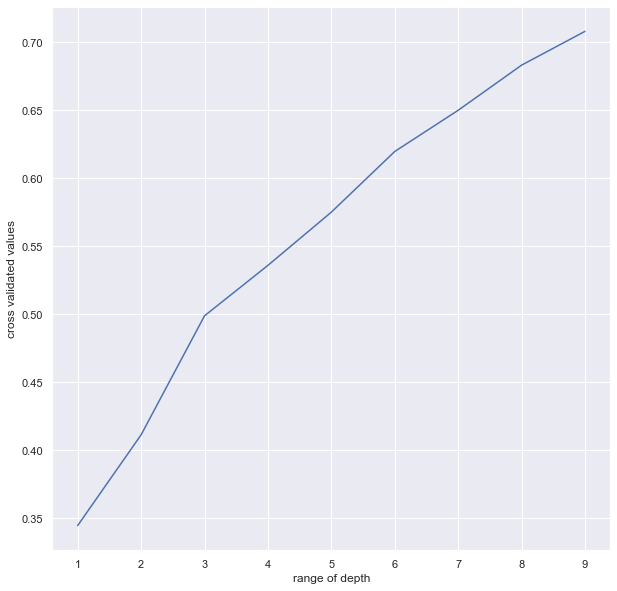

In [376]:
decision_tree_best_model(balanced['X_train'], balanced['y_train'])

In [377]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 6)

Confusion Matrix, without normalization
[[ 88  32  10  52  19]
 [ 34 131  19  32  26]
 [  1   4  25   0   1]
 [  4   6   2  21   1]
 [  4   0   0   5  16]]


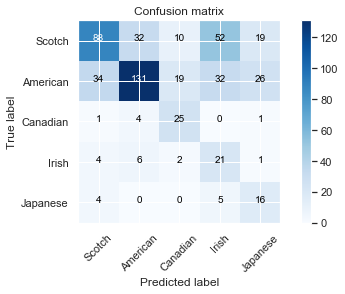

In [378]:
score_model(decision_tree_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [379]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
84,LogisticRegression,SMOTE Tomek,0.477,0.668,0.477,0.525,0.682
85,KNeighborsClassifier,SMOTE Tomek,0.989,0.989,0.989,0.989,0.992
86,KNeighborsClassifier,SMOTE Tomek,0.989,0.989,0.989,0.989,0.992
87,DecisionTreeClassifier,SMOTE Tomek,0.492,0.650,0.492,0.515,0.672


### Random Forest

In [380]:
random_forest_model = random_forest(balanced['X_train'], balanced['y_train'], None, True)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Confusion Matrix, without normalization
[[198   3   0   0   0]
 [  1 241   0   0   0]
 [  0   0  31   0   0]
 [  0   0   0  34   0]
 [  0   0   0   0  25]]


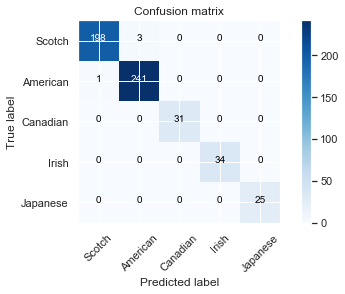

In [381]:
score_model(random_forest_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [382]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
85,KNeighborsClassifier,SMOTE Tomek,0.989,0.989,0.989,0.989,0.992
86,KNeighborsClassifier,SMOTE Tomek,0.989,0.989,0.989,0.989,0.992
87,DecisionTreeClassifier,SMOTE Tomek,0.492,0.650,0.492,0.515,0.672
88,DecisionTreeClassifier,SMOTE Tomek,0.527,0.647,0.527,0.556,0.697


In [383]:
# n_estimators = [10, 50, 100, 150, 200]
# max_features = ['auto', 'sqrt','log2', 14]
# max_depth =[2,5,7,10]
# min_samples_leaf=[1]
# min_samples_split=[2]
# bootstrap = [True, False]

n_estimators = [200]
max_features = ['auto']
max_depth =[10]
min_samples_leaf=[1]
min_samples_split=[2]
bootstrap = [True]

# Create the random grid
param_grid = {  'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split,
                'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [200], 'max_features': ['auto'], 'max_depth': [10], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [True]}


In [384]:
params = grid_search_cv(random_forest_model, features, target, param_grid, 4, 5)
print (params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [385]:
random_forest_model = random_forest(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[172   9   5  13   2]
 [  4 225   7   4   2]
 [  0   2  29   0   0]
 [  2   2   0  30   0]
 [  0   0   0   1  24]]


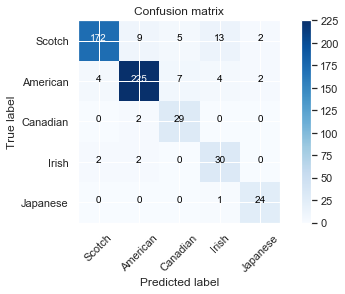

In [386]:
score_model(random_forest_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [387]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
86,KNeighborsClassifier,SMOTE Tomek,0.989,0.989,0.989,0.989,0.992
87,DecisionTreeClassifier,SMOTE Tomek,0.492,0.650,0.492,0.515,0.672
88,DecisionTreeClassifier,SMOTE Tomek,0.527,0.647,0.527,0.556,0.697
89,RandomForestClassifier,SMOTE Tomek,0.992,0.993,0.992,0.992,0.993


### Adaptive Boosting

In [388]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], None, True)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=42)


Confusion Matrix, without normalization
[[ 66  28  15  48  44]
 [ 37 107  59  23  16]
 [  3   2  21   5   0]
 [ 10   2   5  13   4]
 [  7   2   0   1  15]]


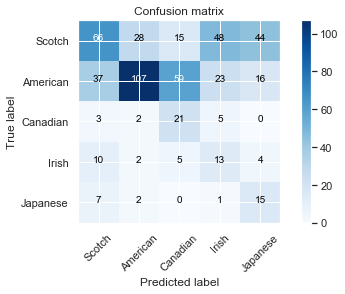

In [389]:
score_model(adaboost_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [390]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
87,DecisionTreeClassifier,SMOTE Tomek,0.492,0.650,0.492,0.515,0.672
88,DecisionTreeClassifier,SMOTE Tomek,0.527,0.647,0.527,0.556,0.697
89,RandomForestClassifier,SMOTE Tomek,0.992,0.993,0.992,0.992,0.993
90,RandomForestClassifier,SMOTE Tomek,0.901,0.915,0.901,0.904,0.935


In [391]:
# n_estimators = [500, 1000, 2000]
# learning_rate = [.001,0.01,.1]
# random_state = [42]

n_estimators = [500]
learning_rate = [.1]
random_state = [42]

param_grid = {  'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'random_state': random_state
             }
print(param_grid)

{'n_estimators': [500], 'learning_rate': [0.1], 'random_state': [42]}


In [392]:
params = grid_search_cv(adaboost_model, features, target, param_grid, 4, 5)
print (params)

{'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 42}


In [393]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[ 86  34  11  39  31]
 [ 29 143  45  14  11]
 [  3   3  21   4   0]
 [ 11   5   6  10   2]
 [  5   3   0   0  17]]


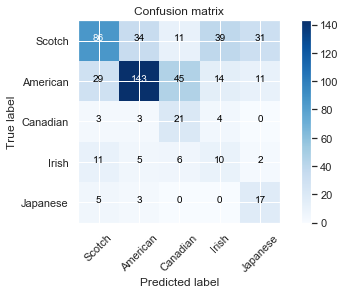

In [394]:
score_model(adaboost_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [395]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
88,DecisionTreeClassifier,SMOTE Tomek,0.527,0.647,0.527,0.556,0.697
89,RandomForestClassifier,SMOTE Tomek,0.992,0.993,0.992,0.992,0.993
90,RandomForestClassifier,SMOTE Tomek,0.901,0.915,0.901,0.904,0.935
91,AdaBoostClassifier,SMOTE Tomek,0.417,0.577,0.417,0.453,0.637


### Gradient Boost

In [396]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], None, True)

Confusion Matrix, without normalization
[[60 17 55 13 56]
 [26 83 91 11 31]
 [ 0  1 23  1  6]
 [ 3  0 15  3 13]
 [ 4  0  1  0 20]]


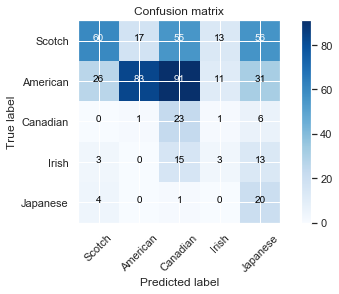

In [397]:
score_model(gradient_boost_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [398]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
89,RandomForestClassifier,SMOTE Tomek,0.992,0.993,0.992,0.992,0.993
90,RandomForestClassifier,SMOTE Tomek,0.901,0.915,0.901,0.904,0.935
91,AdaBoostClassifier,SMOTE Tomek,0.417,0.577,0.417,0.453,0.637
92,AdaBoostClassifier,SMOTE Tomek,0.520,0.625,0.520,0.548,0.688


In [399]:
# param_grid = {
#     "loss":["deviance", "exponential"],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "min_samples_split": [2],
#     "min_samples_leaf": [1],
#     "max_depth":[3,5,10],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[1.0],
#     "n_estimators":[50, 100, 200]
#     }

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.1],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[10],
    "max_features":["auto"],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
    "n_estimators":[100]
    }


# print(param_grid)

In [400]:
params = grid_search_cv(gradient_boost_model, features, target, param_grid, 4, 5)
print (params)

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [401]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[197   4   0   0   0]
 [  1 241   0   0   0]
 [  0   0  31   0   0]
 [  0   0   0  34   0]
 [  0   0   0   0  25]]


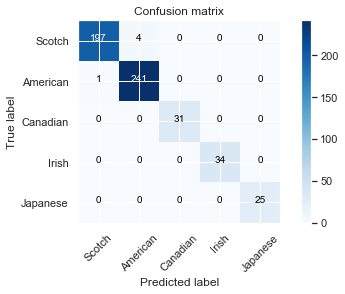

In [402]:
score_model(gradient_boost_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [403]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
90,RandomForestClassifier,SMOTE Tomek,0.901,0.915,0.901,0.904,0.935
91,AdaBoostClassifier,SMOTE Tomek,0.417,0.577,0.417,0.453,0.637
92,AdaBoostClassifier,SMOTE Tomek,0.520,0.625,0.520,0.548,0.688
93,GradientBoostingClassifier,SMOTE Tomek,0.355,0.638,0.355,0.405,0.629


### XGBoost

In [404]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], None, True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Confusion Matrix, without normalization
[[138  21   8  22  12]
 [ 22 185  17   8  10]
 [  1   5  25   0   0]
 [ 12   5   3  13   1]
 [  4   2   0   1  18]]


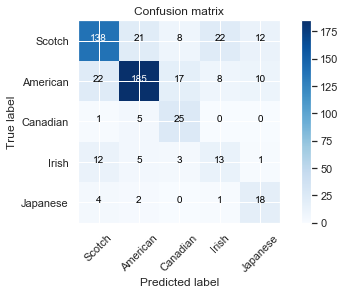

In [405]:
score_model(xgboost_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [406]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
91,AdaBoostClassifier,SMOTE Tomek,0.417,0.577,0.417,0.453,0.637
92,AdaBoostClassifier,SMOTE Tomek,0.520,0.625,0.520,0.548,0.688
93,GradientBoostingClassifier,SMOTE Tomek,0.355,0.638,0.355,0.405,0.629
94,GradientBoostingClassifier,SMOTE Tomek,0.991,0.991,0.991,0.991,0.992


In [407]:
# param_grid = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

param_grid = {
        'min_child_weight': [10],
        'gamma': [1.5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5]
        }

# print(param_grid)

In [408]:
params = grid_search_cv(xgboost_model, features, target, param_grid, 4, 5)
print (params)

{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0}


In [409]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[161  18   5  13   4]
 [ 16 213   6   5   2]
 [  1   5  24   1   0]
 [  7   4   1  22   0]
 [  3   2   0   0  20]]


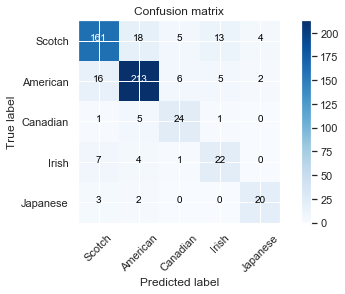

In [410]:
score_model(xgboost_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [411]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
92,AdaBoostClassifier,SMOTE Tomek,0.520,0.625,0.520,0.548,0.688
93,GradientBoostingClassifier,SMOTE Tomek,0.355,0.638,0.355,0.405,0.629
94,GradientBoostingClassifier,SMOTE Tomek,0.991,0.991,0.991,0.991,0.992
95,XGBClassifier,SMOTE Tomek,0.711,0.746,0.711,0.722,0.803


### Naive Bayes

In [412]:
naive_bayes_model = naive_bayes(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 67  37  13  66  18]
 [ 18 137  38  39  10]
 [  0   2  22   6   1]
 [  3   7   8  13   3]
 [  3   1   2   7  12]]


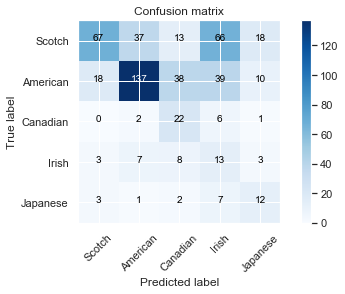

In [413]:
score_model(naive_bayes_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [414]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.670,0.608,0.670,0.630,0.726
1,KNeighborsClassifier,None,0.632,0.636,0.632,0.631,0.726
2,KNeighborsClassifier,None,0.696,0.678,0.696,0.672,0.762
3,DecisionTreeClassifier,None,0.630,0.548,0.630,0.583,0.690
4,DecisionTreeClassifier,None,0.630,0.586,0.630,0.605,0.699
...,...,...,...,...,...,...,...
93,GradientBoostingClassifier,SMOTE Tomek,0.355,0.638,0.355,0.405,0.629
94,GradientBoostingClassifier,SMOTE Tomek,0.991,0.991,0.991,0.991,0.992
95,XGBClassifier,SMOTE Tomek,0.711,0.746,0.711,0.722,0.803
96,XGBClassifier,SMOTE Tomek,0.826,0.832,0.826,0.828,0.873


In [416]:
summary_df.to_csv("results_summary.csv")